The purpose of the project is to predict the number of drivers needed in Manhattan based on weather data, hour, day of the week, and area in Manhattan


# gather functions 
 and other functions i used and created during the project




In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import re

import pandas as pd


#-----------------------------------------------------------------GATHER FUNCTION-----------------------------------------------------------------


#convert the month data from parquet to csv
def convert_parquet_to_csv():

    path_soruce =r'Raw data- all zones parquet'
    all_files = glob.glob(path_soruce + "/*.parquet")

    for filename in all_files:

        df = pd.read_parquet(filename)

        
        # remove_uncrecessy_features(df)
        df.rename(columns={'tpep_pickup_datetime':'pickup_datetime'}, inplace=True)
        #rename columns
        df.rename(columns={'tpep_dropoff_datetime':'dropoff_datetime'}, inplace=True)
        df_clean = df[['pickup_datetime','dropoff_datetime','passenger_count','trip_distance','PULocationID','DOLocationID']]

        
        # #find digits in string
        index = re.findall(r'\d+', filename)
        #convert the list to string
        index = ''.join(index)


        save_path = 'All zones csv\{}.csv'.format(index)
        #save df to csv file
        df_clean.to_csv(save_path)



In [71]:
#-----------------------------------------------------------------DATA_PREP_FUNCTION-----------------------------------------------------------------
import pandas as pd

def get_weather_data() :
    """ Returns the Weather CSV as a Datframe

    Returns:
        pd.DataFrame: Contains the Weather Data
    """
    weather_df = pd.read_csv('Weather Data\weather.csv')

    weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%d/%m/%Y')
    weather_df.rename(columns={'Date': 'pickup_date'}, inplace=True)

    #remove strings and letters from the features
    weather_df['Precipitation'].replace('T', '0.00001', inplace=True)
    weather_df['New Snow'].replace('T', '0.00001', inplace=True)
    weather_df['Snow Depth'].replace('T', '0.00001', inplace=True)

    # convert types from object to float
    weather_df['Precipitation'] = weather_df['Precipitation'].astype(float)
    weather_df['New Snow'] = weather_df['New Snow'].astype(float)
    weather_df['Snow Depth'] = weather_df['Snow Depth'].astype(float)
    return weather_df

    

# #Create List of the all ZoneID in Manhattan
def get_manhattan_zones_ID():
    nyc_zones = pd.read_csv('taxi_zones.csv')
    manhattan_zones = nyc_zones.loc[nyc_zones['borough']== 'Manhattan']
    manhattan_zones_ID = manhattan_zones['LocationID'].tolist()
    return manhattan_zones_ID


def get_hours_label(min: int, max: int):
    """ the function creates a list of labels in the format 00:00 - 00:59 for
        example

    Args:
        min (int): min hour (0)
        max (int): max hour (24)

    Returns:
        List: Returns a list of strings ( labels )
    """
    return [f'{s:02d}:00 - {s:02d}:59' for s in range(min, max)]


#calulate the time difference between pickup_datetime and dropoff_datetime
def time_delta(time1: pd.Series, time2: pd.Series) -> pd.Series:
    return (time2-time1).dt.total_seconds()/60



def get_outliers(df: pd.DataFrame, series: pd.Series):
    """Returns Outliers"""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)

    if q1*q3 == 0:
        iqr = abs(2*(q1+q3))
        toprange = iqr
        botrange = -toprange
    else:
        iqr = q3-q1
        toprange = q3 + iqr * 1.5
        botrange = q1 - iqr * 1.5

    outliers_top = df[series > toprange]
    outliers_bot = df[series < botrange]
    outliers = pd.concat([outliers_bot, outliers_top], axis=0)

    return (botrange, toprange, outliers)


In [ ]:
# #-----------------------------------------------------------------function to clean DATABASES-----------------------------------------------------------------
""" Reading the all taxi a Datframes and cleaning them

Returns:
    pd.DataFrame: processed  data and Contains the Weather Data
"""

# Variables
twenty_four_hours_labels = get_hours_label(0, 24)
weather_df = get_weather_data()
manhattan_zones_ID = get_manhattan_zones_ID()
li = []

#path 
path_all_zones_csv = r'All zones csv'
all_files = glob.glob(path_all_zones_csv + "/*.csv")


def clean_databases():


    for filename in all_files:


        #find digits in string
        index = re.findall(r'\d+', filename)
        #convert the list to string
        index = ''.join(index)


        print("Step 1: Reading the file: {}".format(index))

        main_df = pd.read_csv(filename, index_col=None, header=0)
        
        #use the manhattan_zones_ID to filter for manhattan data only
        main_df = main_df.loc[main_df['PULocationID'].isin(manhattan_zones_ID)]


        print('Step 1 Completed')

        print("Step 2: Remove duplicates and replacing the Nan's At \
            Passenger_Count to 1 ")
        
        #replace nan in passenger_count with 1 (the target feature)
        main_df['passenger_count'].fillna(1, inplace=True)
        
        main_df.drop_duplicates(inplace=True)

        main_df.dropna(inplace=True)  # Drops rows with Nan values

        print("Step 2 Completed")

        print("Step 3: Changing features")

        # Converting the Date columns to DateTime type.
        main_df['pickup_datetime'] = pd.to_datetime(main_df['pickup_datetime'])
        main_df['dropoff_datetime'] = pd.to_datetime(main_df['dropoff_datetime'])

        # Getting the delta between the pick up and drop off in a new column.
        main_df['trip_time'] = time_delta(
            main_df['pickup_datetime'], main_df['dropoff_datetime'])

        # Creating a speed column
        main_df['speed'] = (main_df.trip_distance / (main_df.trip_time / 60))

        # Creating a PU date and time
        main_df['pickup_date'] = pd.to_datetime(main_df['pickup_datetime']).dt.date
        main_df['pickup_time'] = pd.to_datetime(main_df['pickup_datetime']).dt.time
        main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date'])

        # Creating Time Bins
        bins = [x for x in range(25)]
        main_df['time_binned'] = pd.cut(
            main_df.pickup_datetime.dt.hour, bins, labels=twenty_four_hours_labels,
            right=False)

        print('Step 3 Completed')

        print('Step 4: Remove unnecessary Features and Outliers')

        # Drops unneccery features
        to_drop = [x for x in main_df.passenger_count if x >= 5] #remove passenger_count > 5
        main_df = main_df[~main_df.passenger_count.isin(to_drop)]

        to_drop = [x for x in main_df.passenger_count if x <= 0]#remove passenger_count < 0
        main_df = main_df[~main_df.passenger_count.isin(to_drop)]

        to_drop = [x for x in main_df.trip_distance if x <= 0]#remove trip_distance < 0
        main_df = main_df[~main_df.trip_distance.isin(to_drop)]

        to_drop = [x for x in main_df.trip_time if x <= 0]#remove trip_time < 0
        main_df = main_df[~main_df.trip_time.isin(to_drop)]

        to_drop = [x for x in main_df.pickup_datetime.dt.year if x != 2019]#remove year != 2019
        main_df = main_df[~main_df.pickup_datetime.dt.year.isin(to_drop)]

        to_drop = [x for x in main_df.trip_time if x > 720] #remove trip_time > 12 hours
        main_df = main_df[~main_df.trip_time.isin(to_drop)]

        to_drop = [x for x in main_df.speed if x <= 0] #remove speed < 0
        main_df = main_df[~main_df.speed.isin(to_drop)]


        Numindex = int(index)
        to_drop = [x for x in main_df.pickup_date.dt.month if x != Numindex] #remove month != index
        main_df = main_df[~main_df.pickup_date.dt.month.isin(to_drop)]

        # Find the Outliers for Speed, trip distance and trip time
        botrange, toprange, outliers = get_outliers(main_df, main_df['speed'])
        to_drop = [x for x in main_df.speed if x > toprange or x < botrange]
        main_no_outliers_df = main_df[~main_df.speed.isin(to_drop)]
        botrange, toprange, outliers = get_outliers(
            main_df, main_df['trip_distance'])
        to_drop = [x for x in main_df.trip_distance if x >
                toprange or x < botrange]
        main_no_outliers_df = main_df[~main_df.trip_distance.isin(to_drop)]
        botrange, toprange, outliers = get_outliers(
            main_df, main_df['trip_time'])
        to_drop = [x for x in main_df.trip_time if x > toprange or x < botrange]
        main_no_outliers_df = main_df[~main_df.trip_time.isin(to_drop)]
        main_no_outliers_df.reset_index(inplace=True, drop=True)
        main_df = main_no_outliers_df
        print('Step 4 Completed')


        print('Step 5: Merge with Weather Data')
        
        weather_df['pickup_date'] = pd.to_datetime(weather_df["pickup_date"].dt.strftime('%Y-%m-%d')) 

        main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date'])

        main_df.sort_values('pickup_date', inplace=True)
        main_df = pd.merge_asof(main_df, weather_df, on='pickup_date')

        print('Step 5: Completed')



        print('Step 6: Removing unnecessary features and fixing Weather Data')
        main_df.drop(['pickup_datetime'], axis=1, inplace=True)
        main_df.drop(['pickup_time'], axis=1, inplace=True)

        main_df['Precipitation'].replace('T', '0.00001', inplace=True)
        main_df['New Snow'].replace('T', '0.00001', inplace=True)
        main_df['Snow Depth'].replace('T', '0.00001', inplace=True)

        main_df['Precipitation'] = main_df['Precipitation'].astype(float)
        main_df['New Snow'] = main_df['New Snow'].astype(float)
        main_df['Snow Depth'] = main_df['Snow Depth'].astype(float)
        print('Step 6 Completed')

        print('Step 7: Groupby')
        main_df = main_df.groupby(
            ['PULocationID', 'pickup_date', 'time_binned']
        ).agg({
            'Tmax': 'mean',
            'Tmin': 'mean',
            'Tavg': 'mean',
            'Tdep': 'mean',
            'HDD': 'mean',
            'CDD': 'mean',
            'Precipitation': 'mean',
            'New Snow': 'mean',
            'Snow Depth': 'mean',
            'trip_distance': 'mean',
            'trip_time': 'mean',
            'speed': 'mean',
            'passenger_count': 'count',
        }).reset_index()
        main_df['weekday'] = main_df['pickup_date'].dt.day_name()
        main_df.rename(columns={'passenger_count': 'num_of_taxis',
                                'New Snow': 'new_snow', 'Snow Depth': 'snow_depth',
                                'PULocationID': 'zone'},
                    inplace=True)
        main_df = main_df[['zone', 'pickup_date', 'weekday', 'time_binned', 'Tmax',
                        'Tmin',
                        'Tavg', 'Tdep', 'HDD', 'CDD', 'Precipitation',
                        'new_snow', 'snow_depth', 'trip_distance', 'trip_time',
                        'speed', 'num_of_taxis']]
        print('Step 7 Completed')

        print('Step 8: Save the DB')

        save_path = 'clean database\Clean_Data_{}.csv'.format(index)

        #save df to csv file
        main_df.to_csv(save_path)
        
        
        print('Step 8 Completed')

    print('Finish')



# Data Processing


In [58]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import sys


In [59]:
#Create List of the all ZoneID in Manhattan
def get_manhattan_zones_ID():
    nyc_zones = pd.read_csv('taxi_zones.csv')
    manhattan_zones = nyc_zones.loc[nyc_zones['borough']== 'Manhattan']
    manhattan_zones_ID = manhattan_zones['LocationID'].tolist()
    return manhattan_zones_ID

I only took area 237 to run on a relatively small amount of data, so bring the following operations that will process the large base

In [60]:
#read csv files




# path_all_zones_csv = r'All zones csv'
path_zone_237 =r'Raw Data 237'
all_files = glob.glob(path_zone_237 + "/*.csv")

li = []
manhattan_zones_ID=get_manhattan_zones_ID()


for filename in all_files:
    print("import file: {}".format(filename))
    df = pd.read_csv(filename, index_col=None, header=0)
    
    #use the manhattan_zones_ID to filter the data
    df = df.loc[df['PULocationID'].isin(manhattan_zones_ID)]


    li.append(df)

main_df  = pd.concat(li, axis=0, ignore_index=True)
main_df



import file: Raw Data 237\1.csv
import file: Raw Data 237\10.csv
import file: Raw Data 237\11.csv
import file: Raw Data 237\12.csv
import file: Raw Data 237\2.csv
import file: Raw Data 237\3.csv
import file: Raw Data 237\4.csv
import file: Raw Data 237\5.csv
import file: Raw Data 237\6.csv
import file: Raw Data 237\7.csv
import file: Raw Data 237\8.csv
import file: Raw Data 237\9.csv


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID
0,2019-01-01 00:32:59,2019-01-01 00:32:59,3.0,0.00,237,264
1,2019-01-01 00:00:00,2019-01-01 01:03:12,2.0,7.37,237,264
2,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263
3,2019-01-01 00:42:41,2019-01-01 00:55:14,1.0,2.12,237,263
4,2019-01-01 00:24:43,2019-01-01 00:30:13,1.0,1.00,237,140
...,...,...,...,...,...,...
3641677,2019-09-30 16:57:03,2019-09-30 17:59:37,NaN,14.10,237,72
3641678,2019-09-30 17:10:00,2019-09-30 18:04:00,NaN,9.83,237,106
3641679,2019-09-30 19:11:00,2019-09-30 19:40:00,NaN,8.92,237,182
3641680,2019-09-30 23:32:00,2019-09-30 23:58:00,NaN,12.58,237,197


step 1- remove duplicates and replacing the Nan's of feature target

In [61]:
main_df.info()
print("\n------------------------------------\n     nulls values:\n",main_df.isna().sum())


#check if have duplicates
duplicates= main_df.duplicated().sum()
print("\n------------------------------------\n      sum of duplicates:",duplicates)
print("\n------------------------------------\n ")
main_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3641682 entries, 0 to 3641681
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   pickup_datetime   object 
 1   dropoff_datetime  object 
 2   passenger_count   float64
 3   trip_distance     float64
 4   PULocationID      int64  
 5   DOLocationID      int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 166.7+ MB

------------------------------------
     nulls values:
 pickup_datetime        0
dropoff_datetime       0
passenger_count     2322
trip_distance          0
PULocationID           0
DOLocationID           0
dtype: int64

------------------------------------
      sum of duplicates: 5916

------------------------------------
 


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID
0,2019-01-01 00:32:59,2019-01-01 00:32:59,3.0,0.00,237,264
1,2019-01-01 00:00:00,2019-01-01 01:03:12,2.0,7.37,237,264
2,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263
3,2019-01-01 00:42:41,2019-01-01 00:55:14,1.0,2.12,237,263
4,2019-01-01 00:24:43,2019-01-01 00:30:13,1.0,1.00,237,140
...,...,...,...,...,...,...
3641677,2019-09-30 16:57:03,2019-09-30 17:59:37,NaN,14.10,237,72
3641678,2019-09-30 17:10:00,2019-09-30 18:04:00,NaN,9.83,237,106
3641679,2019-09-30 19:11:00,2019-09-30 19:40:00,NaN,8.92,237,182
3641680,2019-09-30 23:32:00,2019-09-30 23:58:00,NaN,12.58,237,197


In [62]:
#replace nan in passenger_count with 1 (the target feature)
main_df['passenger_count'].fillna(1, inplace=True)


In [63]:
# Drops rows with Nan values
main_df.dropna(inplace=True)

#remove duplicates
main_df.drop_duplicates(inplace=True)
main_df


,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID
0,2019-01-01 00:32:59,2019-01-01 00:32:59,3.0,0.00,237,264
1,2019-01-01 00:00:00,2019-01-01 01:03:12,2.0,7.37,237,264
2,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263
3,2019-01-01 00:42:41,2019-01-01 00:55:14,1.0,2.12,237,263
4,2019-01-01 00:24:43,2019-01-01 00:30:13,1.0,1.00,237,140
...,...,...,...,...,...,...
3641677,2019-09-30 16:57:03,2019-09-30 17:59:37,1.0,14.10,237,72
3641678,2019-09-30 17:10:00,2019-09-30 18:04:00,1.0,9.83,237,106
3641679,2019-09-30 19:11:00,2019-09-30 19:40:00,1.0,8.92,237,182
3641680,2019-09-30 23:32:00,2019-09-30 23:58:00,1.0,12.58,237,197


step 2 - Changing features

In [64]:
# Converting the Date columns to DateTime type.
main_df['pickup_datetime'] = pd.to_datetime(main_df['pickup_datetime'])
main_df['dropoff_datetime'] = pd.to_datetime(main_df['dropoff_datetime'])



#Creating Pickup Date and Time columns and pickup_date type of date
main_df['pickup_date'] = pd.to_datetime(main_df['pickup_datetime']).dt.date
main_df['pickup_time'] = pd.to_datetime(main_df['pickup_datetime']).dt.time
# main_df['pickup_datetime'] = pd.to_datetime(main_df['pickup_date'])---delete? 
main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date'])


# #split columns dropoff_datetime to date and time
main_df['dropoff_date'] = pd.to_datetime(main_df['dropoff_datetime']).dt.date
main_df['dropoff_time'] = pd.to_datetime(main_df['dropoff_datetime']).dt.time

#calculate the time delta between pickup and dropoff
t1 = main_df['pickup_datetime']
t2 = main_df['dropoff_datetime']
main_df['trip_time'] = (t2 - t1).dt.total_seconds()/60

#calculate the speed
main_df['speed'] = (main_df.trip_distance / (main_df.trip_time / 60))
#calucate speed in miles per mintues
# main_df['speed_mph'] = (main_df.trip_distance / (main_df.trip_time / 60)) * 2.2369

step 3- Remove unnecessary Features and Outliers

In [65]:
#--------------------- remove junk data  from all zones dataframe------------------------------
# # num of passengers > 5
# to_drop = [x for x in main_df.passenger_count if x >= 5] 
# main_df = main_df[~main_df.passenger_count.isin(to_drop)] 

# # num of passengers < 0
# to_drop = [x for x in main_df.passenger_count if x <= 0]
# main_df = main_df[~main_df.passenger_count.isin(to_drop)]

# # trip distance < 0
# to_drop = [x for x in main_df.trip_distance if x <= 0] 
# main_df = main_df[~main_df.trip_distance.isin(to_drop)]

# # trip time <= 0
# to_drop = [x for x in main_df.trip_time if x <= 0]
# main_df = main_df[~main_df.trip_time.isin(to_drop)]

# #dates not from 2019
# to_drop = [x for x in main_df.pickup_datetime.dt.year if x != 2019]
# main_df = main_df[~main_df.pickup_datetime.dt.year.isin(to_drop)]

# #times >12 hours
# to_drop = [x for x in main_df.trip_time if x > 720]
# main_df = main_df[~main_df.trip_time.isin(to_drop)]

# #speed <0
# to_drop = [x for x in main_df.speed if x <= 0]
# main_df = main_df[~main_df.speed.isin(to_drop)]

# to_drop = [x for x in main_df.pickup_date.dt.month if x != index] #remove all the rows with the differnce month
# main_df = main_df[~main_df.pickup_date.dt.month.isin(to_drop)]



#------------------------- remove junk data from the dataframe -(zone 237) ------------------------------
main_df.drop(main_df[main_df['passenger_count'] >= 5].index,axis=0,inplace=True) # num of passengers > 5
main_df.drop(main_df[main_df['passenger_count'] < 0].index,axis=0,inplace=True) # num of passengers < 0
main_df.drop(main_df[main_df['trip_distance'] <= 0].index,axis=0,inplace=True) # trip distance < 0
main_df.drop(main_df[main_df['trip_time'] <= 0].index,axis=0,inplace=True) # trip time <= 0
main_df.drop(main_df[main_df['pickup_datetime'].dt.year != 2019].index,axis=0,inplace=True) # dates not from 2019
main_df.drop(main_df[main_df['trip_time'] > 720].index,axis=0,inplace= True) # time > 12 hours
main_df.drop(main_df[main_df['speed'] <=  0 ].index,axis=0,inplace= True) # speed <= 0

main_df

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_time,speed
1,2019-01-01 00:00:00,2019-01-01 01:03:12,2.0,7.37,237,264,2019-01-01,00:00:00,2019-01-01,01:03:12,63.200000,6.996835
2,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263,2019-01-01,00:36:01,2019-01-01,00:47:36,11.583333,8.650360
3,2019-01-01 00:42:41,2019-01-01 00:55:14,1.0,2.12,237,263,2019-01-01,00:42:41,2019-01-01,00:55:14,12.550000,10.135458
4,2019-01-01 00:24:43,2019-01-01 00:30:13,1.0,1.00,237,140,2019-01-01,00:24:43,2019-01-01,00:30:13,5.500000,10.909091
5,2019-01-01 00:39:55,2019-01-01 00:51:01,1.0,1.90,237,238,2019-01-01,00:39:55,2019-01-01,00:51:01,11.100000,10.270270
...,...,...,...,...,...,...,...,...,...,...,...,...
3641677,2019-09-30 16:57:03,2019-09-30 17:59:37,1.0,14.10,237,72,2019-09-30,16:57:03,2019-09-30,17:59:37,62.566667,13.521577
3641678,2019-09-30 17:10:00,2019-09-30 18:04:00,1.0,9.83,237,106,2019-09-30,17:10:00,2019-09-30,18:04:00,54.000000,10.922222
3641679,2019-09-30 19:11:00,2019-09-30 19:40:00,1.0,8.92,237,182,2019-09-30,19:11:00,2019-09-30,19:40:00,29.000000,18.455172
3641680,2019-09-30 23:32:00,2019-09-30 23:58:00,1.0,12.58,237,197,2019-09-30,23:32:00,2019-09-30,23:58:00,26.000000,29.030769


Find and removing Outliers

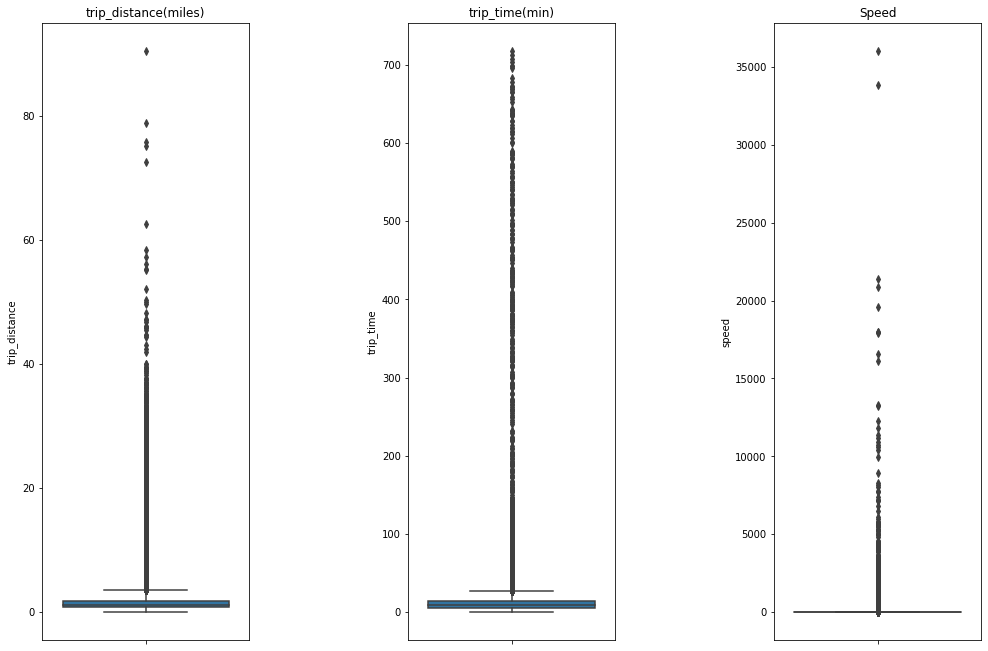

In [66]:
fig, axes = plt.subplots(1, 3)
sns.boxplot(data=main_df,y='trip_distance',orient='v',ax=axes[0])
sns.boxplot(data=main_df,y='trip_time',orient='v',ax=axes[1])
sns.boxplot(data=main_df,y='speed',orient='v',ax=axes[2])
axes[0].set_title("trip_distance(miles)")
axes[1].set_title("trip_time(min)")
axes[2].set_title("Speed")
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(15)

In [67]:
# Find the Outliers for Speed, trip distance and trip time
# Add a outlier detection function using IQR
def get_outliers(df, series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  if q1*q3 == 0:
    iqr = abs(2*(q1+q3))
    toprange = iqr
    botrange = -toprange
  else:
    iqr = q3-q1
    toprange = q3 + iqr * 1.5
    botrange = q1 - iqr * 1.5

  outliers_top=df[series > toprange]
  outliers_bot= df[series < botrange]
  outliers = pd.concat([outliers_bot, outliers_top], axis=0)

  return (botrange, toprange, outliers)


# Find the Outliers for Speed
botrange, toprange, outliers = get_outliers(main_df, main_df['speed'])
print(f'speed top range outlier: {toprange}')
print(f'speed bottom range outlier: {botrange}')
index_list = [i for i in main_df.index if i not in outliers.index]
main_no_outliers_df = main_df.loc[index_list]

# Find the Outliers for trip_distance
botrange, toprange, outliers = get_outliers(main_df, main_df['trip_distance'])
print(f'trip_distance top range outlier: {toprange}')
print(f'trip_distance bottom range outlier: {botrange}')
index_list = [i for i in main_no_outliers_df.index if i not in outliers.index]
main_no_outliers_df = main_no_outliers_df.loc[index_list]

# Find the Outliers for trip_time
botrange, toprange, outliers = get_outliers(main_df, main_df['trip_time'])
print(f'trip_time top range outlier: {toprange}')
print(f'trip_time bottom range outlier: {botrange}')
index_list = [i for i in main_no_outliers_df.index if i not in outliers.index]
main_no_outliers_df = main_no_outliers_df.loc[index_list]

# remove the outliers if needed
main_no_outliers_df.reset_index(inplace=True, drop=True)
main_df = main_no_outliers_df


speed top range outlier: 19.099009900990097
speed bottom range outlier: -0.9405940594059414
trip_distance top range outlier: 3.55
trip_distance bottom range outlier: -0.8499999999999999
trip_time top range outlier: 26.95
trip_time bottom range outlier: -7.316666666666666


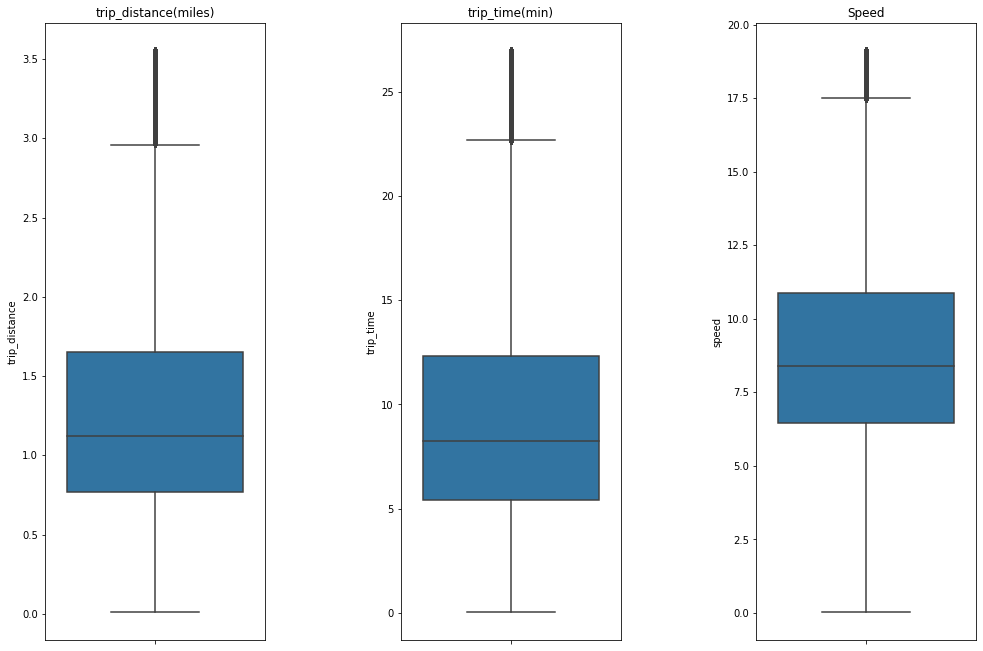

In [68]:
fig, axes = plt.subplots(1, 3)
sns.boxplot(data=main_df,y='trip_distance',orient='v',ax=axes[0])
sns.boxplot(data=main_df,y='trip_time',orient='v',ax=axes[1])
sns.boxplot(data=main_df,y='speed',orient='v',ax=axes[2])
axes[0].set_title("trip_distance(miles)")
axes[1].set_title("trip_time(min)")
axes[2].set_title("Speed")
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(15)

In [69]:
#Creating time bins

def get_hours_label(min: int, max: int):
    """ the function creates a list of labels in the format 00:00 - 00:59 for
        example

    Args:
        min (int): min hour (0)
        max (int): max hour (24)

    Returns:
        List: Returns a list of strings ( labels )
    """
    return [f'{s:02d}:00 - {s:02d}:59' for s in range(min, max)]


labels = get_hours_label(0, 24)
bins = [x for x in range(25)]

main_df['time_binned'] = pd.cut(main_df.pickup_datetime.dt.hour, bins, labels=labels, right=False)


In [184]:
#sort pickup_datetime
main_df.sort_values(by='pickup_date',inplace=True)
check_df = main_df
check_df

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_time,speed,time_binned
0,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263,2019-01-01,00:36:01,2019-01-01,00:47:36,11.583333,8.650360,00:00 - 00:59
2572,2019-01-01 16:15:33,2019-01-01 16:26:21,3.0,2.60,237,90,2019-01-01,16:15:33,2019-01-01,16:26:21,10.800000,14.444444,16:00 - 16:59
2573,2019-01-01 16:03:53,2019-01-01 16:06:42,1.0,0.59,237,236,2019-01-01,16:03:53,2019-01-01,16:06:42,2.816667,12.568047,16:00 - 16:59
2574,2019-01-01 16:24:40,2019-01-01 16:31:49,3.0,1.93,237,239,2019-01-01,16:24:40,2019-01-01,16:31:49,7.150000,16.195804,16:00 - 16:59
2575,2019-01-01 15:58:09,2019-01-01 16:01:45,1.0,0.57,237,237,2019-01-01,15:58:09,2019-01-01,16:01:45,3.600000,9.500000,15:00 - 15:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086736,2019-12-31 17:10:17,2019-12-31 17:15:36,0.0,0.80,237,236,2019-12-31,17:10:17,2019-12-31,17:15:36,5.316667,9.028213,17:00 - 17:59
1086737,2019-12-31 17:35:27,2019-12-31 17:52:22,1.0,2.97,237,79,2019-12-31,17:35:27,2019-12-31,17:52:22,16.916667,10.533990,17:00 - 17:59
1086738,2019-12-31 17:39:33,2019-12-31 17:46:23,1.0,1.18,237,162,2019-12-31,17:39:33,2019-12-31,17:46:23,6.833333,10.360976,17:00 - 17:59
1086728,2019-12-31 17:21:53,2019-12-31 17:44:42,1.0,2.29,237,143,2019-12-31,17:21:53,2019-12-31,17:44:42,22.816667,6.021914,17:00 - 17:59


In [186]:
main_df = check_df


Step 4- merge with Weather Data

In [187]:
weather_df = pd.read_csv('Weather Data\weather.csv')
weather_df.info()

#rename Date to pickup_date
weather_df.rename(columns={'Date':'pickup_date'},inplace=True)


# convert  dtype from object to date
weather_df['pickup_date'] = pd.to_datetime(weather_df['pickup_date'],format='%d/%m/%Y')

weather_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Tmax           365 non-null    int64  
 2   Tmin           365 non-null    int64  
 3   Tavg           365 non-null    float64
 4   Tdep           365 non-null    float64
 5   HDD            365 non-null    int64  
 6   CDD            365 non-null    int64  
 7   Precipitation  365 non-null    object 
 8   New Snow       365 non-null    object 
 9   Snow Depth     365 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 28.6+ KB


,pickup_date,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2019-01-01,58,39,48.5,13.3,16,0,0.06,0,0
1,2019-01-02,40,35,37.5,2.5,27,0,0,0,0
2,2019-01-03,44,37,40.5,5.7,24,0,0,0,0
3,2019-01-04,47,35,41.0,6.3,24,0,0,0,0
4,2019-01-05,47,41,44.0,9.5,21,0,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,54,46,50.0,13.8,15,0,0,0,0
361,2019-12-28,51,43,47.0,11.0,18,0,0,0,0
362,2019-12-29,44,39,41.5,5.7,23,0,0.25,0,0
363,2019-12-30,41,37,39.0,3.4,26,0,0.74,T,0


In [188]:
#sorted values by pickup_date before the merge
main_df.sort_values(by='pickup_date',inplace=True)


In [189]:
# merge the weather data with the main data

# main_df = pd.merge(main_df, weather_df, on='pickup_date', how='left')
main_df = pd.merge_asof(main_df, weather_df, on='pickup_date')



main_df

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,pickup_date,pickup_time,dropoff_date,dropoff_time,...,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2019-01-01 00:36:01,2019-01-01 00:47:36,1.0,1.67,237,263,2019-01-01,00:36:01,2019-01-01,00:47:36,...,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
1,2019-01-01 00:42:41,2019-01-01 00:55:14,1.0,2.12,237,263,2019-01-01,00:42:41,2019-01-01,00:55:14,...,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
2,2019-01-01 00:24:43,2019-01-01 00:30:13,1.0,1.00,237,140,2019-01-01,00:24:43,2019-01-01,00:30:13,...,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
3,2019-01-01 00:39:55,2019-01-01 00:51:01,1.0,1.90,237,238,2019-01-01,00:39:55,2019-01-01,00:51:01,...,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
4,2019-01-01 00:29:04,2019-01-01 00:36:33,2.0,1.90,237,262,2019-01-01,00:29:04,2019-01-01,00:36:33,...,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995924,2019-12-31 11:04:10,2019-12-31 11:20:44,2.0,2.40,237,75,2019-12-31,11:04:10,2019-12-31,11:20:44,...,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0,0
2995925,2019-12-31 11:16:29,2019-12-31 11:24:33,1.0,1.38,237,161,2019-12-31,11:16:29,2019-12-31,11:24:33,...,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0,0
2995926,2019-12-31 11:20:28,2019-12-31 11:26:15,1.0,0.80,237,141,2019-12-31,11:20:28,2019-12-31,11:26:15,...,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0,0
2995927,2019-12-31 11:20:36,2019-12-31 11:23:32,1.0,0.35,237,43,2019-12-31,11:20:36,2019-12-31,11:23:32,...,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0,0


Step 5: Removing unnecessary features and fixing Weather Data

In [190]:
#drop columons are not necessary

main_df.drop(['pickup_datetime','pickup_time'], axis=1, inplace=True)
main_df.head(5)

,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,pickup_date,dropoff_date,dropoff_time,trip_time,speed,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2019-01-01 00:47:36,1.0,1.67,237,263,2019-01-01,2019-01-01,00:47:36,11.583333,8.650360,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
1,2019-01-01 00:55:14,1.0,2.12,237,263,2019-01-01,2019-01-01,00:55:14,12.550000,10.135458,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
2,2019-01-01 00:30:13,1.0,1.00,237,140,2019-01-01,2019-01-01,00:30:13,5.500000,10.909091,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
3,2019-01-01 00:51:01,1.0,1.90,237,238,2019-01-01,2019-01-01,00:51:01,11.100000,10.270270,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0
4,2019-01-01 00:36:33,2.0,1.90,237,262,2019-01-01,2019-01-01,00:36:33,7.483333,15.233853,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0,0


In [191]:
#remove strings and letters from the features
main_df['Precipitation'].replace('T', '0.00001', inplace=True)
main_df['New Snow'].replace('T', '0.00001', inplace=True)
main_df['Snow Depth'].replace('T', '0.00001', inplace=True)

# convert types from object to float
main_df['Precipitation'] = main_df['Precipitation'].astype(float)
main_df['New Snow'] = main_df['New Snow'].astype(float)
main_df['Snow Depth'] = main_df['Snow Depth'].astype(float)
main_df

,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,pickup_date,dropoff_date,dropoff_time,trip_time,speed,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2019-01-01 00:47:36,1.0,1.67,237,263,2019-01-01,2019-01-01,00:47:36,11.583333,8.650360,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0.0,0.0
1,2019-01-01 00:55:14,1.0,2.12,237,263,2019-01-01,2019-01-01,00:55:14,12.550000,10.135458,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0.0,0.0
2,2019-01-01 00:30:13,1.0,1.00,237,140,2019-01-01,2019-01-01,00:30:13,5.500000,10.909091,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0.0,0.0
3,2019-01-01 00:51:01,1.0,1.90,237,238,2019-01-01,2019-01-01,00:51:01,11.100000,10.270270,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0.0,0.0
4,2019-01-01 00:36:33,2.0,1.90,237,262,2019-01-01,2019-01-01,00:36:33,7.483333,15.233853,00:00 - 00:59,58,39,48.5,13.3,16,0,0.06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995924,2019-12-31 11:20:44,2.0,2.40,237,75,2019-12-31,2019-12-31,11:20:44,16.566667,8.692153,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0.0,0.0
2995925,2019-12-31 11:24:33,1.0,1.38,237,161,2019-12-31,2019-12-31,11:24:33,8.066667,10.264463,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0.0,0.0
2995926,2019-12-31 11:26:15,1.0,0.80,237,141,2019-12-31,2019-12-31,11:26:15,5.783333,8.299712,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0.0,0.0
2995927,2019-12-31 11:23:32,1.0,0.35,237,43,2019-12-31,2019-12-31,11:23:32,2.933333,7.159091,11:00 - 11:59,45,36,40.5,5.1,24,0,0.02,0.0,0.0


step 6 - groupby

In [193]:

#check how many columons contain null values
main_df.isna().any().sum()


0

In [194]:
#display the  features with  null values
main_df.isna().sum()

dropoff_datetime    0
passenger_count     0
trip_distance       0
PULocationID        0
DOLocationID        0
pickup_date         0
dropoff_date        0
dropoff_time        0
trip_time           0
speed               0
time_binned         0
Tmax                0
Tmin                0
Tavg                0
Tdep                0
HDD                 0
CDD                 0
Precipitation       0
New Snow            0
Snow Depth          0
dtype: int64

In [195]:
main_df = main_df.groupby(
        ['PULocationID', 'pickup_date', 'time_binned']
    ).agg({
        'Tmax': 'mean',
        'Tmin': 'mean',
        'Tavg': 'mean',
        'Tdep': 'mean',
        'HDD': 'mean',
        'CDD': 'mean',
        'Precipitation': 'mean',
        'New Snow': 'mean',
        'Snow Depth': 'mean',
        'trip_distance': 'mean',
        'trip_time': 'mean',
        'speed': 'mean',
        'passenger_count': 'count',
    }).reset_index()
main_df


,PULocationID,pickup_date,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,New Snow,Snow Depth,trip_distance,trip_time,speed,passenger_count
0,237,2019-01-01,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.514182,8.956320,11.052748,385
1,237,2019-01-01,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.623159,9.152222,11.157481,345
2,237,2019-01-01,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.696781,8.426484,12.249663,146
3,237,2019-01-01,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.716780,8.064972,13.150890,59
4,237,2019-01-01,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.420690,6.021839,13.946401,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,237,2019-12-31,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.290240,7.502283,10.643271,292
8756,237,2019-12-31,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.240706,7.540105,10.008449,411
8757,237,2019-12-31,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.293894,7.439714,10.763770,303
8758,237,2019-12-31,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.356667,7.490713,11.050091,201


In [196]:
#create new column with 'weekday' name from pickup_datetime
main_df['weekday'] = main_df['pickup_date'].dt.day_name()

In [197]:
main_df.rename(columns={'passenger_count': 'num_of_taxis',
                        'New Snow': 'new_snow', 'Snow Depth': 'snow_depth',
                        'PULocationID': 'zone'},
                inplace=True)
main_df

,zone,pickup_date,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,trip_distance,trip_time,speed,num_of_taxis,weekday
0,237,2019-01-01,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.514182,8.956320,11.052748,385,Tuesday
1,237,2019-01-01,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.623159,9.152222,11.157481,345,Tuesday
2,237,2019-01-01,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.696781,8.426484,12.249663,146,Tuesday
3,237,2019-01-01,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.716780,8.064972,13.150890,59,Tuesday
4,237,2019-01-01,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.420690,6.021839,13.946401,29,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,237,2019-12-31,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.290240,7.502283,10.643271,292,Tuesday
8756,237,2019-12-31,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.240706,7.540105,10.008449,411,Tuesday
8757,237,2019-12-31,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.293894,7.439714,10.763770,303,Tuesday
8758,237,2019-12-31,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.356667,7.490713,11.050091,201,Tuesday


In [198]:

main_df = main_df[['zone', 'pickup_date', 'weekday', 'time_binned', 'Tmax',
                       'Tmin',
                       'Tavg', 'Tdep', 'HDD', 'CDD', 'Precipitation',
                       'new_snow', 'snow_depth', 'trip_distance', 'trip_time',
                       'speed', 'num_of_taxis']]


main_df

,zone,pickup_date,weekday,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,trip_distance,trip_time,speed,num_of_taxis
0,237,2019-01-01,Tuesday,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.514182,8.956320,11.052748,385
1,237,2019-01-01,Tuesday,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.623159,9.152222,11.157481,345
2,237,2019-01-01,Tuesday,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.696781,8.426484,12.249663,146
3,237,2019-01-01,Tuesday,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.716780,8.064972,13.150890,59
4,237,2019-01-01,Tuesday,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.420690,6.021839,13.946401,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,237,2019-12-31,Tuesday,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.290240,7.502283,10.643271,292
8756,237,2019-12-31,Tuesday,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.240706,7.540105,10.008449,411
8757,237,2019-12-31,Tuesday,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.293894,7.439714,10.763770,303
8758,237,2019-12-31,Tuesday,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.356667,7.490713,11.050091,201


In [199]:
#sort the data by zone and pickup_date and time_binned
main_df = main_df.sort_values(by=['zone','pickup_date','time_binned'])


finish the clean the data
created the function -'clean_databases()'  to cleaning the all Databases

In [200]:
#save the cleaning data to csv

# main_df.to_csv('Cleaning_Data.csv', index=False)
main_df

,zone,pickup_date,weekday,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,trip_distance,trip_time,speed,num_of_taxis
0,237,2019-01-01,Tuesday,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.514182,8.956320,11.052748,385
1,237,2019-01-01,Tuesday,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.623159,9.152222,11.157481,345
2,237,2019-01-01,Tuesday,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.696781,8.426484,12.249663,146
3,237,2019-01-01,Tuesday,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.716780,8.064972,13.150890,59
4,237,2019-01-01,Tuesday,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,1.420690,6.021839,13.946401,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,237,2019-12-31,Tuesday,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.290240,7.502283,10.643271,292
8756,237,2019-12-31,Tuesday,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.240706,7.540105,10.008449,411
8757,237,2019-12-31,Tuesday,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.293894,7.439714,10.763770,303
8758,237,2019-12-31,Tuesday,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,1.356667,7.490713,11.050091,201


                                                                            We finished the Episode - Data Processing
We took all the code blocks and created  from them the function clean_databases().

which we will run to clean the large database.

# Statistical tests

imports

In [94]:
import pandas as pd
from scipy import stats 
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr



Load the data

In [107]:
#path
path_clean_data='clean database'
all_files = glob.glob(path_clean_data + "/*.csv")


#load  and merge csv files
all_files = glob.glob(path_clean_data + "/*.csv")

li = []
for filename in all_files:
    print("import file: {}".format(filename))
    main_df = pd.read_csv(filename, index_col=None, header=0)
    li.append(main_df)

main_df  = pd.concat(li, axis=0, ignore_index=True)

main_df = main_df.sort_values(by=['zone','pickup_date','time_binned'])




import file: clean database\Clean_Data_1.csv
import file: clean database\Clean_Data_10.csv
import file: clean database\Clean_Data_11.csv
import file: clean database\Clean_Data_12.csv
import file: clean database\Clean_Data_2.csv
import file: clean database\Clean_Data_3.csv
import file: clean database\Clean_Data_4.csv
import file: clean database\Clean_Data_5.csv
import file: clean database\Clean_Data_6.csv
import file: clean database\Clean_Data_7.csv
import file: clean database\Clean_Data_8.csv
import file: clean database\Clean_Data_9.csv


In [108]:
main_df.drop(['Unnamed: 0'], axis=1, inplace=True)

main_df.dropna(inplace=True)
main_df['pickup_date'] = main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date'])
main_df


,zone,pickup_date,weekday,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,trip_distance,trip_time,speed,num_of_taxis
0,4,2019-01-01,Tuesday,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,2.774419,11.763566,13.091983,43
1,4,2019-01-01,Tuesday,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.236145,15.501004,11.792795,83
2,4,2019-01-01,Tuesday,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,2.830286,12.100000,12.529339,70
3,4,2019-01-01,Tuesday,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.311867,12.615556,14.304606,75
4,4,2019-01-01,Tuesday,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.622432,12.827477,15.137740,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194827,263,2019-12-31,Tuesday,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,2.137276,9.506281,12.722576,268
194828,263,2019-12-31,Tuesday,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,2.168557,9.917784,12.118150,388
194829,263,2019-12-31,Tuesday,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,2.125320,9.895847,13.214219,297
194830,263,2019-12-31,Tuesday,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,2.299054,9.054805,14.414498,222


Stat Test #1 - to find if there are different between the days

In [109]:
uses_per_day = main_df\
    .groupby(['pickup_date'],as_index=False)\
    .agg({'num_of_taxis' : 'sum', 'weekday' : lambda x: x.iloc[1]})
uses_per_day

,pickup_date,num_of_taxis,weekday
0,2019-01-01,143435,Tuesday
1,2019-01-02,152810,Wednesday
2,2019-01-03,175775,Thursday
3,2019-01-04,187988,Friday
4,2019-01-05,192543,Saturday
...,...,...,...
360,2019-12-27,134876,Friday
361,2019-12-28,136804,Saturday
362,2019-12-29,129628,Sunday
363,2019-12-30,139695,Monday


In [110]:
week = {
    'Monday':uses_per_day.loc[uses_per_day['weekday'] == 'Monday'].num_of_taxis.tolist(),
    'Tuesday':uses_per_day.loc[uses_per_day['weekday'] == 'Tuesday'].num_of_taxis.tolist(),
    'Wednesday':uses_per_day.loc[uses_per_day['weekday'] == 'Wednesday'].num_of_taxis.tolist(),
    'Thursday':uses_per_day.loc[uses_per_day['weekday'] == 'Thursday'].num_of_taxis.tolist(),
    'Friday':uses_per_day.loc[uses_per_day['weekday'] == 'Friday'].num_of_taxis.tolist(),
    'Saturday':uses_per_day.loc[uses_per_day['weekday'] == 'Saturday'].num_of_taxis.tolist(),
    'Sunday':uses_per_day.loc[uses_per_day['weekday'] == 'Sunday'].num_of_taxis.tolist()
}

In [111]:
#anova test one way between weekdays
stat, p = stats.f_oneway(
                        week.get('Sunday'),
                        week.get('Monday'),
                        week.get('Tuesday'),
                        week.get('Wednesday'),
                        week.get('Thursday'),
                        week.get('Friday'),
                        week.get('Saturday')
)
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

Probably different distributions


In [112]:
# t test between weekdays

duplicates_list = []
for day1,value1 in week.items():
    for day2,value2 in week.items():
        if day1 == day2:
            continue
        stat, p = stats.ttest_ind(value1,value2)
        if p > 0.05:
            if(day2 + day1 not in duplicates_list):
                duplicates_list.append(day1+day2)
                print(f'{day1} and {day2} probably have same distribution. P-Value = {p}')

Tuesday and Wednesday probably have same distribution. P-Value = 0.09590233069078494
Tuesday and Saturday probably have same distribution. P-Value = 0.7451588682015289
Wednesday and Thursday probably have same distribution. P-Value = 0.3382456653780944
Wednesday and Friday probably have same distribution. P-Value = 0.4995944317670433
Wednesday and Saturday probably have same distribution. P-Value = 0.25337566570777065
Thursday and Friday probably have same distribution. P-Value = 0.7888931319579507
Friday and Saturday probably have same distribution. P-Value = 0.08768299051638455


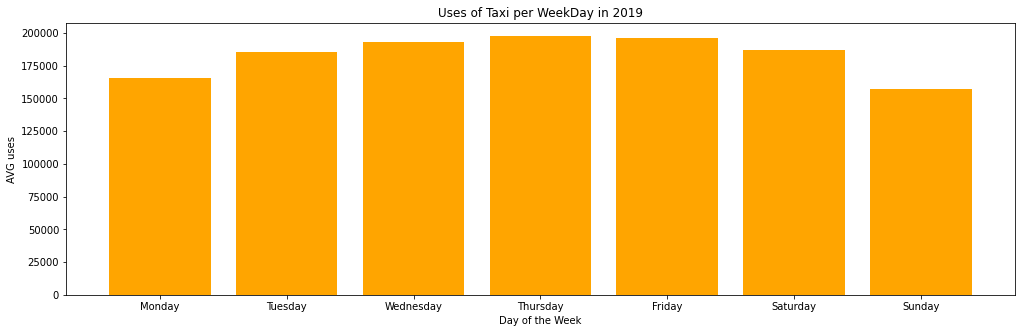

In [113]:
#graph with uses of taxi per week day in year 2019
keys = week.keys()
values = week.values()
values1 = []
for val in values:
    values1.append(np.mean(val))
plt.bar(keys,values1,color = 'orange')
plt.rcParams["figure.figsize"] = (17,5)
plt.xlabel('Day of the Week')
plt.ylabel('AVG uses')
plt.title('Uses of Taxi per WeekDay in 2019')
plt.show()

In [114]:
# #we create dummy variables for the weekdays
week_dummies = pd.get_dummies(main_df['weekday'], prefix='weekday')
main_df = main_df.join(week_dummies)
main_df.drop(['weekday'], axis=1, inplace=True)
main_df

,zone,pickup_date,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,...,trip_time,speed,num_of_taxis,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,4,2019-01-01,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,11.763566,13.091983,43,0,0,0,0,0,1,0
1,4,2019-01-01,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,15.501004,11.792795,83,0,0,0,0,0,1,0
2,4,2019-01-01,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.100000,12.529339,70,0,0,0,0,0,1,0
3,4,2019-01-01,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.615556,14.304606,75,0,0,0,0,0,1,0
4,4,2019-01-01,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.827477,15.137740,37,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194827,263,2019-12-31,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.506281,12.722576,268,0,0,0,0,0,1,0
194828,263,2019-12-31,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.917784,12.118150,388,0,0,0,0,0,1,0
194829,263,2019-12-31,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.895847,13.214219,297,0,0,0,0,0,1,0
194830,263,2019-12-31,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.054805,14.414498,222,0,0,0,0,0,1,0


Stat Test #2 - check if temperatures affecting the number of taxi users 

In [115]:
temp_month_df = main_df[['pickup_date','time_binned','Tmax','Tmin','Tavg','Precipitation','snow_depth','num_of_taxis']]
temp_month_df['month'] = temp_month_df['pickup_date'].dt.month_name()


C:\Users\omrid\AppData\Local\Temp/ipykernel_32556/4154617101.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
#summer_df is the months between June and August
summer_df = temp_month_df.loc[(temp_month_df['month'] == 'June') | (temp_month_df['month'] == 'July') | (temp_month_df['month'] == 'August')]

#winter_df is the months between December and february
winter_df = temp_month_df.loc[(temp_month_df['month'] == 'December') | (temp_month_df['month'] == 'January') | (temp_month_df['month'] == 'February')]

#spring_df is the months between March and May
spring_df = temp_month_df.loc[(temp_month_df['month'] == 'March') | (temp_month_df['month'] == 'April') | (temp_month_df['month'] == 'May')]

#fall_df is the months between September and November
fall_df = temp_month_df.loc[(temp_month_df['month'] == 'September') | (temp_month_df['month'] == 'October') | (temp_month_df['month'] == 'November')]


Text(0.5, 1.0, 'Histogram of the temperature in the summer ')

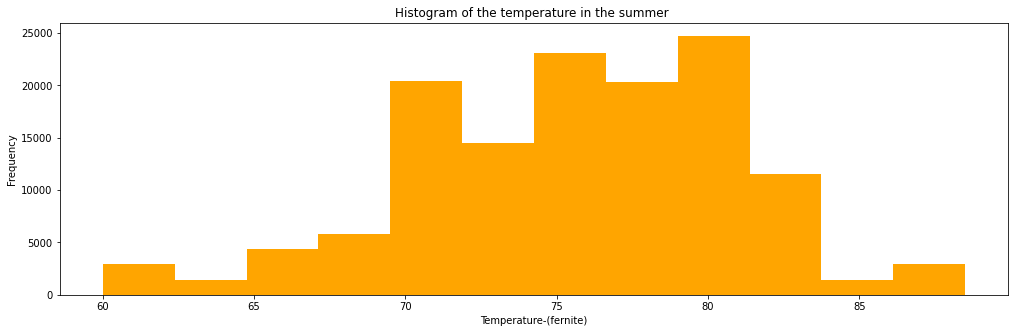

In [117]:
#histogram of the temperatures in the summer
plt.hist(summer_df.Tavg, bins=12, color='orange')
plt.xlabel('Temperature-(fernite)')
plt.ylabel('Frequency')
plt.title('Histogram of the temperature in the summer ')



First i try to find correlation between the AVG temperature and the number of taxis on the whole year.

In [120]:
print('Pearson Correlation:')
corr,p_value = pearsonr(temp_month_df['Tavg'],temp_month_df['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('\nSpearman Correlation:')
corr,p_value = spearmanr(temp_month_df['Tavg'],temp_month_df['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))

Pearson Correlation:
Correlation: -0.0567124437491322
P-Value: 0.0

Spearman Correlation:
Correlation: -0.03463529325845564
P-Value: 3.340310227728431e-140


,zone,pickup_date,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,...,trip_time,speed,num_of_taxis,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,4,2019-01-01,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,11.763566,13.091983,43,0,0,0,0,0,1,0
1,4,2019-01-01,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,15.501004,11.792795,83,0,0,0,0,0,1,0
2,4,2019-01-01,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.100000,12.529339,70,0,0,0,0,0,1,0
3,4,2019-01-01,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.615556,14.304606,75,0,0,0,0,0,1,0
4,4,2019-01-01,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,...,12.827477,15.137740,37,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194827,263,2019-12-31,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.506281,12.722576,268,0,0,0,0,0,1,0
194828,263,2019-12-31,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.917784,12.118150,388,0,0,0,0,0,1,0
194829,263,2019-12-31,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.895847,13.214219,297,0,0,0,0,0,1,0
194830,263,2019-12-31,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,...,9.054805,14.414498,222,0,0,0,0,0,1,0


based on the whole year, we can see there is a low correlation, and that can be because the Tavg is an avg of the temp in the day, can be really cold at night but warm during the day.
Because of that, we are going to find the correlation in a more specific way.

 for example we going to look at the max temperature during the noon at the summer only.

In [121]:

noon = [
            '12:00 - 12:59',
            '13:00 - 13:59',
            '14:00 - 14:59',
            '15:00 - 15:59',
            ]
    
noon_summer_df = summer_df.loc[summer_df['time_binned'].isin(noon)]
noon_winter_df = winter_df.loc[winter_df['time_binned'].isin(noon)]
noon_fall_df = fall_df.loc[fall_df['time_binned'].isin(noon)]
noon_spring_df = spring_df.loc[spring_df['time_binned'].isin(noon)]


In [122]:
print('~~~ SUMMER ~~~')
noon_summer_df_correlation = noon_summer_df.dropna()._get_numeric_data()

print('Pearson Correlation:')
corr,p_value = pearsonr(noon_summer_df_correlation['Tmax'],noon_summer_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('Spearman Correlation:')
corr,p_value = spearmanr(noon_summer_df_correlation['Tmax'],noon_summer_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))

~~~ SUMMER ~~~
Pearson Correlation:
Correlation: -0.01946802624604054
P-Value: 0.0034698965954696494
Spearman Correlation:
Correlation: -0.0066295490239531366
P-Value: 0.3196363783873194


In [123]:
print('~~~ SUMMER ~~~')
noon_summer_df_correlation = noon_summer_df.dropna()._get_numeric_data()

print('Pearson Correlation:')
corr,p_value = pearsonr(noon_summer_df_correlation['Tmax'],noon_summer_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('\nSpearman Correlation:')
corr,p_value = spearmanr(noon_summer_df_correlation['Tmax'],noon_summer_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))

~~~ SUMMER ~~~
Pearson Correlation:
Correlation: -0.01946802624604054
P-Value: 0.0034698965954696494

Spearman Correlation:
Correlation: -0.0066295490239531366
P-Value: 0.3196363783873194


In [124]:
print('~~~ SPRING ~~~')
noon_spring_df_correlation = noon_summer_df.dropna()._get_numeric_data()

print('Pearson Correlation:')
corr,p_value = pearsonr(noon_spring_df_correlation['Tmax'],noon_spring_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('\nSpearman Correlation:')
corr,p_value = spearmanr(noon_spring_df_correlation['Tmax'],noon_spring_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))



~~~ SPRING ~~~
Pearson Correlation:
Correlation: -0.01946802624604054
P-Value: 0.0034698965954696494

Spearman Correlation:
Correlation: -0.0066295490239531366
P-Value: 0.3196363783873194


In [125]:
print('~~~ WINTER ~~~')
noon_winter_df_correlation = noon_winter_df.dropna()._get_numeric_data()

print('Pearson Correlation:')
corr,p_value = pearsonr(noon_winter_df_correlation['Tmax'],noon_winter_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('\nSpearman Correlation:')
corr,p_value = spearmanr(noon_winter_df_correlation['Tmax'],noon_winter_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))


~~~ WINTER ~~~
Pearson Correlation:
Correlation: -0.041756281699095656
P-Value: 5.565008048260036e-10

Spearman Correlation:
Correlation: -0.030621346002742716
P-Value: 5.4303957645300385e-06


In [126]:
print('~~~ FALL ~~~')
noon_fall_df_correlation = noon_fall_df.dropna()._get_numeric_data()
print('Pearson Correlation:')
corr,p_value = pearsonr(noon_fall_df_correlation['Tmax'],noon_fall_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))
print('\nSpearman Correlation:')
corr,p_value = spearmanr(noon_fall_df_correlation['Tmax'],noon_fall_df_correlation['num_of_taxis'])
print('Correlation: '+str(corr))
print('P-Value: '+str(p_value))

~~~ FALL ~~~
Pearson Correlation:
Correlation: -0.044020437970870616
P-Value: 5.138044993891937e-11

Spearman Correlation:
Correlation: -0.03184141449830302
P-Value: 2.044861748817522e-06


Correlation for each month

In [127]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
noon_df = temp_month_df[temp_month_df['time_binned'].isin(noon)]
print("Correlation & P-Value between Tavg and Number of Taxis")

for month in months:
    month_df = noon_df.loc[noon_df['month'] == month].dropna()._get_numeric_data()
    corr,p_value = pearsonr(month_df['Tmax'],month_df['num_of_taxis'])
    print(f'{month} :')
    print(f'Correlation: {format(corr,"0.4f")}')
    print(f'P-Value: {format(p_value,"0.6f")}')

Correlation & P-Value between Tavg and Number of Taxis
January :
Correlation: -0.0291
P-Value: 0.011110
February :
Correlation: -0.0365
P-Value: 0.002463
March :
Correlation: -0.0252
P-Value: 0.027380
April :
Correlation: -0.0047
P-Value: 0.686329
May :
Correlation: -0.0554
P-Value: 0.000001
June :
Correlation: -0.0181
P-Value: 0.120925
July :
Correlation: 0.0102
P-Value: 0.372238
August :
Correlation: 0.0306
P-Value: 0.007796
September :
Correlation: -0.0071
P-Value: 0.544770
October :
Correlation: -0.0218
P-Value: 0.057401
November :
Correlation: -0.0281
P-Value: 0.016272
December :
Correlation: -0.0502
P-Value: 0.000012


The correlation is still low, so let's  build data of 4 groups.
2 groups to check whether it's hotter then they travel more, and 2 groups whether it's colder they travel more.

Each pair of teams will be paired and we will achieve this with the help of a stick all the days in the summer that the maximum temperature will be above 27 degrees, but the following week the maximum temperature will be
below 27 degrees. A sample of the number of taxis was also taken at time bin 14:00 -14:59.
We did the same for winter.



In [128]:
#the 2 groups to check whether it's hotter then they travel more.
hot_days =  []
not_hot_days = []


two_to_three_summer_df = summer_df.loc[summer_df['time_binned'] == '14:00 - 14:59'].groupby('pickup_date',as_index=False).agg({
    'Tmax':'mean',
    'num_of_taxis':'sum'
})


for i,row in two_to_three_summer_df.iterrows():
    if i == len(two_to_three_summer_df)-7: #stop at the last 7 days
        break
    if row.Tmax >= 80 and two_to_three_summer_df.iloc[i+7].Tmax < 80: #if the next 7 days are not hot
        hot_days.append(row.num_of_taxis)   #add the number of taxis to the list of hot days
        not_hot_days.append(two_to_three_summer_df.iloc[i+7].num_of_taxis)  #add the number of taxis to the list of not hot days
hot_days,not_hot_days

([9044,
  10889,
  11039,
  10512,
  9320,
  8415,
  10902,
  9818,
  10039,
  8072,
  7811,
  7962,
  8687,
  8842,
  9063],
 [8028,
  10042,
  9925,
  9863,
  8953,
  7814,
  9213,
  9279,
  8547,
  8253,
  7271,
  7331,
  7407,
  8178,
  8087])

In [129]:
print('number of usage in days <80F')
print(not_hot_days)
print('Mean: ' + str(np.mean(not_hot_days)))
print('Median: '+ str(np.median(not_hot_days)))

number of usage in days <80F
[8028, 10042, 9925, 9863, 8953, 7814, 9213, 9279, 8547, 8253, 7271, 7331, 7407, 8178, 8087]
Mean: 8546.066666666668
Median: 8253.0


Our sample is small so we will use Wilcoxon Test

In [130]:
print('Wilcoxon Test')

stat,p = stats.wilcoxon(hot_days,not_hot_days)
print('P-Value: :',p/2)

if p < 0.05:
    print('H0 rejected : The two groups are different when the temperature is <80F. conclusion the number of taxis used is different')
else:
    print('H0 not rejected : The two groups are the same when the temperature is <80F. conclusion the number of taxis used is the same')
    

Wilcoxon Test
P-Value: : 6.103515625e-05
H0 rejected : The two groups are different when the temperature is <80F. conclusion the number of taxis used is different


In [131]:
#the 2 groups to check whether it's colder then they travel more.
cold_days =  []
not_cold_days = []

two_to_three_winter_df = winter_df.loc[winter_df['time_binned'] == '14:00 - 14:59'].groupby('pickup_date',as_index=False).agg({
    'Tmax':'mean',
    'num_of_taxis':'sum'
})


for i,row in two_to_three_winter_df.iterrows():
    if i == len(two_to_three_winter_df)-7:
        break
    if row.Tmax <= 40 and two_to_three_winter_df.iloc[i+7].Tmax > 40: #if the next 7 days are not cold
        cold_days.append(row.num_of_taxis) #add the number of taxis to the list of cold days
        not_cold_days.append(two_to_three_winter_df.iloc[i+7].num_of_taxis) #add the number of taxis to the list of not cold days
cold_days,not_cold_days

([9299,
  10846,
  11765,
  12176,
  10799,
  10620,
  11508,
  11291,
  13192,
  12277,
  10613,
  9558,
  11076,
  11402,
  9775,
  9536,
  10776,
  11985,
  10500,
  11006,
  11320,
  11980,
  11606,
  11018],
 [11151,
  10451,
  10996,
  11424,
  11120,
  10103,
  11557,
  11693,
  11339,
  9715,
  9891,
  9902,
  11399,
  11356,
  10768,
  9975,
  9288,
  11807,
  9916,
  9529,
  5221,
  7981,
  8810,
  8518])

In [132]:
print('group of not cold days details of of usage in days >40F')
print('Mean: ' + str(np.mean(not_cold_days)))
print('Median: '+ str(np.median(not_cold_days)))

group of not cold days details of of usage in days >40F
Mean: 10162.916666666666
Median: 10277.0


In [133]:
print('group of cold days details of  usage in days <40F , cold days')
print('mean: ' + str(np.mean(cold_days)))
print('median: '+ str(np.median(cold_days)))

group of cold days details of  usage in days <40F , cold days
mean: 11080.166666666666
median: 11047.0


In [134]:
print('Wilcoxon Test')

stat,p = stats.wilcoxon(cold_days,not_cold_days)
print('P-Value: :',p/2)

if p < 0.05:
    print('H0 rejected : the two groups are different ,  in cold days the number of taxis used is different')
else:
    print('H0 not rejected : the two groups are the same ,  in cold days the number of taxis used is the same')

Wilcoxon Test
P-Value: : 0.008203327655792236
H0 rejected : the two groups are different ,  in cold days the number of taxis used is different


In [135]:
print('T-Test paired')

stat,p = stats.ttest_rel(cold_days,not_cold_days,alternative='two-sided')
print('P-Value: '+str(p/2))
  
if p < 0.05:
    print('H0 rejected : the two groups are different ,  in cold days the number of taxis used is different')
else:
    print('H0 not rejected : the two groups are the same ,  in cold days the number of taxis used is the same')

T-Test paired
P-Value: 0.008117562175111689
H0 rejected : the two groups are different ,  in cold days the number of taxis used is different


In [136]:
temp_per_month = temp_month_df.groupby('month',as_index=False,sort=False).agg({'num_of_taxis':'sum','Tavg':'mean'})
temp_per_month


,month,num_of_taxis,Tavg
0,January,6068661,32.523663
1,February,5591023,36.212132
2,March,6208394,41.742559
3,April,5898596,55.461469
4,May,5968046,62.172918
5,June,5467509,71.656996
6,July,4941832,79.575490
7,August,4744685,75.500869
8,September,5175691,70.370201
9,October,5747393,59.909171


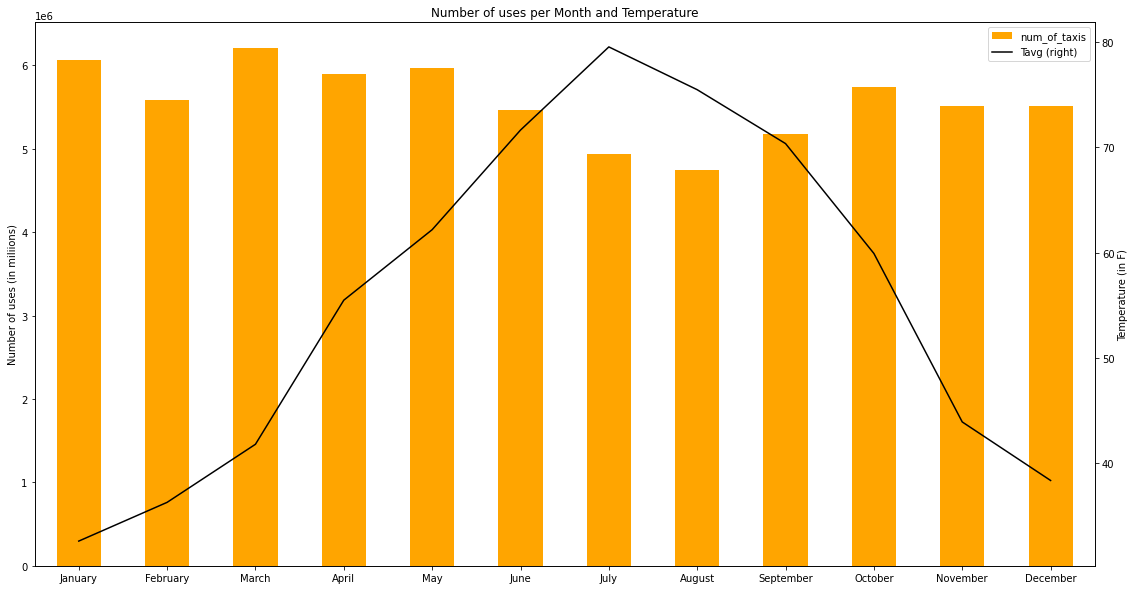

In [137]:
fig, ax = plt.subplots(figsize=(19,10))
temp_per_month.plot(y=['num_of_taxis'],kind='bar',color='orange',ax = ax)
temp_per_month.plot(y=['Tavg'],kind='line',color='black',ax = ax,secondary_y=True)
ax.set_xticklabels(temp_per_month['month'])
plt.title('Number of uses per Month and Temperature')
ax.set_ylabel('Number of uses (in miliions)')
ax.right_ax.set_ylabel('Temperature (in F)')

plt.show()

Statstical test #3 - to find if there are different between hours

In [138]:
uses_per_hour = main_df.groupby('time_binned',as_index=False).agg({'num_of_taxis':'sum'})
uses_per_hour

,time_binned,num_of_taxis
0,00:00 - 00:59,1946440
1,01:00 - 01:59,1397581
2,02:00 - 02:59,995881
3,03:00 - 03:59,689850
4,04:00 - 04:59,509506
5,05:00 - 05:59,569483
6,06:00 - 06:59,1371382
7,07:00 - 07:59,2462783
8,08:00 - 08:59,3082536
9,09:00 - 09:59,3141895


In [139]:
hours = main_df['time_binned'].explode().unique() 


hours_dict = {h:[] for h in hours} #create a dictionary with the hours as keys and empty lists as values

for hour in hours_dict: 
    hours_dict[hour] = main_df.loc[main_df['time_binned'] == hour].num_of_taxis.tolist() 


In [140]:
stat,p = stats.kruskal( 
                        hours_dict.get('00:00 - 00:59'),
                        hours_dict.get('01:00 - 01:59'),
                        hours_dict.get('02:00 - 02:59'),
                        hours_dict.get('03:00 - 03:59'),
                        hours_dict.get('04:00 - 04:59'),
                        hours_dict.get('05:00 - 05:59'),
                        hours_dict.get('06:00 - 06:59'),
                        hours_dict.get('07:00 - 07:59'),
                        hours_dict.get('08:00 - 08:59'),
                        hours_dict.get('09:00 - 09:59'),
                        hours_dict.get('10:00 - 10:59'),
                        hours_dict.get('11:00 - 11:59'),
                        hours_dict.get('12:00 - 12:59'),
                        hours_dict.get('13:00 - 13:59'),
                        hours_dict.get('14:00 - 14:59'),
                        hours_dict.get('15:00 - 15:59'),
                        hours_dict.get('16:00 - 16:59'),
                        hours_dict.get('17:00 - 17:59'),
                        hours_dict.get('18:00 - 18:59'),
                        hours_dict.get('19:00 - 19:59'),
                        hours_dict.get('20:00 - 20:59'),
                        hours_dict.get('21:00 - 21:59'),
                        hours_dict.get('22:00 - 22:59'),
                        hours_dict.get('23:00 - 23:59')
                )
if p > 0.05:
        print('H0 not rejected :  Probably the same distribution') 
else:
	print('H0 rejected :  Probably different distributions')

H0 rejected :  Probably different distributions


In [141]:
#use wilcoxon test to check which hours have same distribution

duplicates_list = []
raw_alpha = []
hours_connections = []
alpha = 0.05 

for hour1,val1 in hours_dict.items(): 
    for hour2,val2 in hours_dict.items(): 
        if hour1 == hour2: 
            continue
        stat,p = stats.mannwhitneyu(val1,val2) 
        if hour2 + hour1 not in duplicates_list: 
            raw_alpha.append(p) 
            hours_connections.append(hour1+' '+hour2) 
            duplicates_list.append(hour1 + hour2)
            if p > alpha:
                print(f'{hour1} and {hour2} probably have same distribution')

03:00 - 03:59 and 04:00 - 04:59 probably have same distribution
09:00 - 09:59 and 10:00 - 10:59 probably have same distribution
11:00 - 11:59 and 16:00 - 16:59 probably have same distribution
11:00 - 11:59 and 22:00 - 22:59 probably have same distribution
12:00 - 12:59 and 13:00 - 13:59 probably have same distribution
13:00 - 13:59 and 15:00 - 15:59 probably have same distribution
14:00 - 14:59 and 15:00 - 15:59 probably have same distribution
14:00 - 14:59 and 21:00 - 21:59 probably have same distribution
15:00 - 15:59 and 21:00 - 21:59 probably have same distribution
16:00 - 16:59 and 22:00 - 22:59 probably have same distribution


In [142]:
d = {'hours':hours_connections,'raw_alpha':raw_alpha}
hours_p_value = pd.DataFrame(d)
rejected, p_adjusted, _, alpha_corrected = multipletests(hours_p_value.raw_alpha,alpha=alpha,method = 'holm',is_sorted=False, returnsorted=False)


In [143]:
hours_with_same_dist_bonferroni = hours_p_value.loc[np.invert(rejected)]
hours_with_same_dist_bonferroni.reset_index(inplace=True,drop=True)
hours_with_same_dist_bonferroni

,hours,raw_alpha
0,03:00 - 03:59 04:00 - 04:59,0.898530
1,09:00 - 09:59 10:00 - 10:59,0.207174
2,10:00 - 10:59 22:00 - 22:59,0.049766
3,11:00 - 11:59 16:00 - 16:59,0.495186
4,11:00 - 11:59 22:00 - 22:59,0.192292
5,12:00 - 12:59 13:00 - 13:59,0.742819
6,12:00 - 12:59 14:00 - 14:59,0.021076
7,12:00 - 12:59 15:00 - 15:59,0.035391
8,13:00 - 13:59 14:00 - 14:59,0.044987
9,13:00 - 13:59 15:00 - 15:59,0.073211


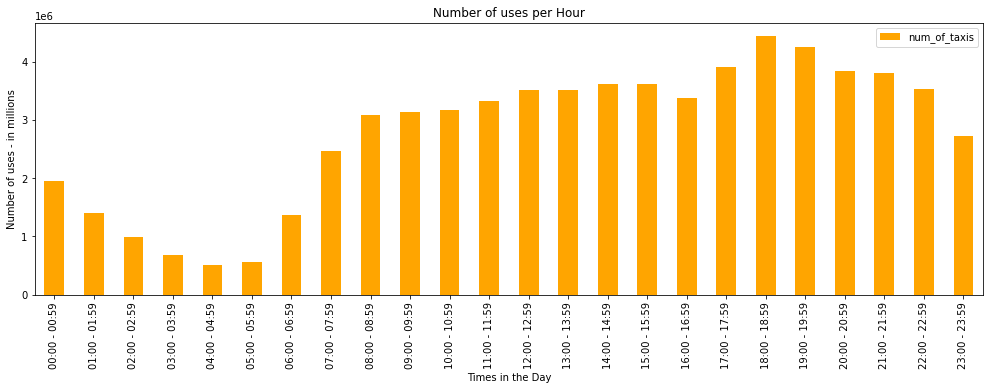

In [144]:
uses_per_hour.plot('time_binned', 'num_of_taxis', kind='bar', rot=90,color='orange')
plt.title('Number of uses per Hour')
plt.xlabel('Times in the Day')
plt.ylabel('Number of uses - in millions')
plt.show()

In [145]:
# def  check if the data is normally distributed
def is_normal(data): 
    stat, p = stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


In [146]:
is_normal(uses_per_hour['num_of_taxis'])


Statistics=0.879, p=0.008
Sample does not look Gaussian (reject H0)


                                                                                            finished the episode of statistics
We found that there is an effect in differences in weather data , in hours , days values and Seasons 

--------------------------

# backward forward  scripts

In [1]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
sys.path.append("..")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import glob

# functions of utility
#functions for this section

def get_dummies(cat_features: list, df: pd.DataFrame): # -> pd.DataFrame:
    """ Converts the catergorial features to a numeric features

    Args:
        cat_features (list): List of the catergorial features in the dataframe
                             that yo want to turn into numeric features
        df (pd.DataFrame): The DataFrame which u want to convert
                            the catergorial features to numeric features

    Returns:
        pd.DataFrame: dateframe with converted features
    """
    for feature in cat_features:
        temp_dummy = pd.get_dummies(df[feature])
        df = pd.concat([temp_dummy, df], axis=1)
    df = df.drop(cat_features, axis=1)
    return df




def swap_first_and_last_col(df: pd.DataFrame) -> pd.DataFrame:
    """swaps the columns location in the Datframe, replace between the first
         and last

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    cols = df.columns.to_list()
    df = df[cols[-1:] + cols[:-1]]
    return df


def split_X_y(df: pd.DataFrame, target_feature: str) :#-> Tuple[List[str],pd.DataFrame]:
    """ split the data into two, dataframe with out the target feature,
        and an array of the target feature.

    Args:
        df (pd.DataFrame): Dataframe
        target_feature (_type_): the target feature you want to train your
                                 model for

    Returns:
        List, pd.pd.DataFrame: y,X
    """
    y = df[target_feature]
    temp = df.drop(target_feature, axis=1)
    X = temp
    return y, X


In [76]:
#path
path_clean_data='clean database'
all_files = glob.glob(path_clean_data + "/*.csv")


#load  and merge csv files
all_files = glob.glob(path_clean_data + "/*.csv")
#
# manhattan_zones_ID=get_manhattan_zones_ID()


li = []
for filename in all_files:
    print("import file: {}".format(filename))
    main_df = pd.read_csv(filename, index_col=None, header=0)
    # df = df.loc[df['zone'].isin(manhattan_zones_ID)]

    li.append(main_df)

main_df  = pd.concat(li, axis=0, ignore_index=True)

main_df = main_df.sort_values(by=['zone','pickup_date','time_binned'])


main_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date'])
main_df.dropna(inplace=True)
main_df = main_df.drop(main_df[main_df.trip_time < 5].index)
main_df = main_df.drop('pickup_date',axis=1)
main_df['zone'] = main_df['zone'].astype(str)
# main_df.reset_index(inplace=True,drop=True)
main_df.drop(['trip_distance','trip_time','speed'],axis=1,inplace=True)


main_df

import file: clean database\Clean_Data_1.csv
import file: clean database\Clean_Data_10.csv
import file: clean database\Clean_Data_11.csv
import file: clean database\Clean_Data_12.csv
import file: clean database\Clean_Data_2.csv
import file: clean database\Clean_Data_3.csv
import file: clean database\Clean_Data_4.csv
import file: clean database\Clean_Data_5.csv
import file: clean database\Clean_Data_6.csv
import file: clean database\Clean_Data_7.csv
import file: clean database\Clean_Data_8.csv
import file: clean database\Clean_Data_9.csv


,zone,weekday,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,num_of_taxis
0,4,Tuesday,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,43
1,4,Tuesday,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,83
2,4,Tuesday,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,70
3,4,Tuesday,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,75
4,4,Tuesday,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194827,263,Tuesday,19:00 - 19:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,268
194828,263,Tuesday,20:00 - 20:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,388
194829,263,Tuesday,21:00 - 21:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,297
194830,263,Tuesday,22:00 - 22:59,45.0,36.0,40.5,5.1,24.0,0.0,0.02,0.0,0.0,222


check correlation between the features


In [77]:

import seaborn as sns
import plotly.express as px
import numpy as np

corr_df = main_df.corr().abs()

fig = px.imshow(corr_df, text_auto=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=500,)

fig.show()



In [78]:
print ('check  high correlation  between the features')
cols = corr_df.columns.to_list()
corr_list = []
for i in range(len(cols)):
  print(cols[i], ': ', end=' ')
  for j in range(len(cols)):
    if abs(corr_df.iloc[i,j]) >= 0.85 and cols[i] is not cols[j] :
      corr_list.append(cols[i])
      print(cols[j], end=', ')
  print()

check  high correlation  between the features
Tmax :  Tmin, Tavg, HDD, 
Tmin :  Tmax, Tavg, HDD, 
Tavg :  Tmax, Tmin, HDD, 
Tdep :  
HDD :  Tmax, Tmin, Tavg, 
CDD :  
Precipitation :  
new_snow :  
snow_depth :  
num_of_taxis :  


In [79]:
# drop the features with high correlation
main_df = main_df.drop(['Tmax','Tmin','HDD'], axis=1)

main_df

,zone,weekday,time_binned,Tavg,Tdep,CDD,Precipitation,new_snow,snow_depth,num_of_taxis
0,4,Tuesday,00:00 - 00:59,48.5,13.3,0.0,0.06,0.0,0.0,43
1,4,Tuesday,01:00 - 01:59,48.5,13.3,0.0,0.06,0.0,0.0,83
2,4,Tuesday,02:00 - 02:59,48.5,13.3,0.0,0.06,0.0,0.0,70
3,4,Tuesday,03:00 - 03:59,48.5,13.3,0.0,0.06,0.0,0.0,75
4,4,Tuesday,04:00 - 04:59,48.5,13.3,0.0,0.06,0.0,0.0,37
...,...,...,...,...,...,...,...,...,...,...
194827,263,Tuesday,19:00 - 19:59,40.5,5.1,0.0,0.02,0.0,0.0,268
194828,263,Tuesday,20:00 - 20:59,40.5,5.1,0.0,0.02,0.0,0.0,388
194829,263,Tuesday,21:00 - 21:59,40.5,5.1,0.0,0.02,0.0,0.0,297
194830,263,Tuesday,22:00 - 22:59,40.5,5.1,0.0,0.02,0.0,0.0,222


running Univariate selection and feature importence to compare between them

In [81]:
X = main_df.drop('num_of_taxis', axis=1)
y = main_df['num_of_taxis']


#dummy variables


X = get_dummies(['weekday','time_binned','zone'], X)


In [87]:
# Feature score  - feature importance
features = X.columns.tolist()
model_lr = LinearRegression()
model_lr.fit(X,y)
importance = model_lr.coef_

for i,v in enumerate(importance):
	print(f'Feature: {features[i]}, Score: {v:.2f}]')

feature_dict = {'Features':features,'Score':importance}
feature_importance_sorted = pd.DataFrame(feature_dict).sort_values(by = ['Score'],ascending=True)['Features']



Feature: 100, Score: 7535441831.14]
Feature: 107, Score: 7535441851.62]
Feature: 113, Score: 7535441788.50]
Feature: 114, Score: 7535441768.31]
Feature: 116, Score: 7535441668.35]
Feature: 12, Score: 7535441638.94]
Feature: 120, Score: 7535441654.87]
Feature: 125, Score: 7535441707.34]
Feature: 127, Score: 7535441649.55]
Feature: 128, Score: 7535441632.35]
Feature: 13, Score: 7535441731.50]
Feature: 137, Score: 7535441761.11]
Feature: 140, Score: 7535441811.96]
Feature: 141, Score: 7535441860.79]
Feature: 142, Score: 7535441916.39]
Feature: 143, Score: 7535441760.23]
Feature: 144, Score: 7535441742.38]
Feature: 148, Score: 7535441764.95]
Feature: 151, Score: 7535441735.27]
Feature: 152, Score: 7535441665.53]
Feature: 153, Score: 7535441646.24]
Feature: 158, Score: 7535441745.19]
Feature: 161, Score: 7535442002.22]
Feature: 162, Score: 7535441965.58]
Feature: 163, Score: 7535441883.03]
Feature: 164, Score: 7535441855.79]
Feature: 166, Score: 7535441705.64]
Feature: 170, Score: 753544192

In [93]:
feature_importance_sorted.tail(20)

62           79
43          239
24          163
39          234
14          142
27          170
57           48
35          230
28          186
23          162
40          236
22          161
41          237
93       Sunday
91       Monday
95      Tuesday
92     Saturday
96    Wednesday
90       Friday
94     Thursday
Name: Features, dtype: object

                                                                                            finished the episode of Feature Selection

The lowest score is on the days of the week and we know that they are important to us, so there are no columns that can be deleted

----------

# Neural network Model

Because the number of taxis is not necessarily the number of drivers actually needed, so we divided the database according to 3 types of interval time of trips

- Short trips
- Medium trips
- Long trips

In the distribution of time, there was also consideration for splitting a database that would be approximately equal in size to each of the networks

In [1]:
import pandas as pd
import sys
sys.path.append("..")
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras_tuner import Hyperband




In [2]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, #patience is the number of epochs to wait before early stopping
                                        restore_best_weights = True) #restore the best weights after early stopping

In [3]:
def get_test_train_data(df):

    y,X = split_X_y(df,'num_of_taxis')
    X_train_scaler = StandardScaler()
    X_test_scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1357)

    X_train_scaled = X_train_scaler.fit_transform(X_train)
    X_test_scaled = X_test_scaler.fit_transform(X_test)
    return X_train_scaled,X_test_scaled,y_train,y_test

In [4]:
# Option One, Rmse about ~68 but will return nan's after some iteration.
def build_model(hp):
  model = keras.Sequential() #create a sequential model
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512,step=32)
  model.add(layers.Dense(units=hp_units1, activation='relu'))
  model.add(layers.Dense(units=hp_units2, activation='relu'))
  model.add(layers.Dense(units=hp_units3, activation='relu'))
  model.add(layers.Dense(units=hp_units4, activation='relu'))
  model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))


  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss='mse',
      metrics=['mse']
  )
  return model

In [5]:
def get_best_network(df:pd.DataFrame,df_name:str):
    
    get_test_train_data(df)
    X_train_scaled,X_test_scaled,y_train,y_test = get_test_train_data(df) 


    tuner = Hyperband(
    build_model, 
    objective='mse',#objective is the metric to optimize
    max_epochs=10,
    directory='keras_tuner_mse',
    project_name=f'{df_name}'
    )

    tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2) #validation_split is the percentage of data to use for validation
    for h_param in [f"units{i}" for i in range(1,4)]:#loop through the hyperparameters
        print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))#get the best hyperparameters
   
    return tuner.get_best_models(num_models=1)[0],X_train_scaled,y_train ,X_test_scaled ,y_test,tuner.get_best_models(num_models=1)[0].evaluate(X_train_scaled, y_train)  #return the best model and the evaluation of the best model on the training set
    



In [6]:
# Option One, Rmse about ~68 but will return nan's after some iteration.
def build_model(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512,step=32)
  model.add(layers.Dense(units=hp_units1, activation='relu'))
  model.add(layers.Dense(units=hp_units2, activation='relu'))
  model.add(layers.Dense(units=hp_units3, activation='relu'))
  model.add(layers.Dense(units=hp_units4, activation='relu'))
  model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))


  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss='mse',
      metrics=['mse']
  )
  return model

In [7]:
def train_model(best_model,X_train_scaled,y_train):
    hist = best_model.fit(
    X_train_scaled, 
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks =[earlystopping]
    )
    return hist , best_model
    

In [4]:

def get_dummies(cat_features: list, df: pd.DataFrame): # -> pd.DataFrame:
    """ Converts the catergorial features to a numeric features

    Args:
        cat_features (list): List of the catergorial features in the dataframe
                             that yo want to turn into numeric features
        df (pd.DataFrame): The DataFrame which u want to convert
                            the catergorial features to numeric features

    Returns:
        pd.DataFrame: dateframe with converted features
    """
    for feature in cat_features:
        temp_dummy = pd.get_dummies(df[feature])
        df = pd.concat([temp_dummy, df], axis=1)
    df = df.drop(cat_features, axis=1)
    return df




def swap_first_and_last_col(df: pd.DataFrame) -> pd.DataFrame:
    """swaps the columns location in the Datframe, replace between the first
         and last

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    cols = df.columns.to_list()
    df = df[cols[-1:] + cols[:-1]]
    return df


def split_X_y(df: pd.DataFrame, target_feature: str) :#-> Tuple[List[str],pd.DataFrame]:
    """ split the data into two, dataframe with out the target feature,
        and an array of the target feature.

    Args:
        df (pd.DataFrame): Dataframe
        target_feature (_type_): the target feature you want to train your
                                 model for

    Returns:
        List, pd.pd.DataFrame: y,X
    """
    y = df[target_feature]
    temp = df.drop(target_feature, axis=1)
    X = temp
    return y, X


In [26]:
import glob
import numpy as np

In [33]:

#path
def import_model():
    path_clean_data='clean database'

    #load  and merge csv files
    all_files = glob.glob(path_clean_data + "/*.csv")

    li = []
    for filename in all_files:
        print("import file: {}".format(filename))
        df = pd.read_csv(filename, index_col=0, header=0)
        li.append(df)

    main_df  = pd.concat(li, axis=0, ignore_index=True)

    main_df = main_df.sort_values(by=['zone','pickup_date','time_binned'])


    main_df.dropna(inplace=True)
    main_df.reset_index(inplace=True,drop=True)

    ##convert zone feature to string
    main_df['zone'] = main_df['zone'].astype(str)

    #

    main_df.dropna(inplace=True)
    main_df.drop_duplicates(inplace=True)
    main_df.drop(['pickup_date', 'trip_distance', 'speed'], axis=1, inplace=True) #drop unneeded features

    main_df = main_df.drop(['Tmax','Tmin','HDD'], axis=1) #remove features with high correlation

    main_df['trip_time'] = main_df.trip_time.apply(np.ceil) #round up trip time to nearest integer
    main_df = get_dummies(['weekday','time_binned','zone'],main_df) #dummy variables before we split to 3 sets

    # Lower the column names
    main_df = main_df.rename(columns=lambda x: x.lower())


    return main_df


main_df =import_model()
main_df

import file: clean database\Clean_Data_1.csv
import file: clean database\Clean_Data_10.csv
import file: clean database\Clean_Data_11.csv
import file: clean database\Clean_Data_12.csv
import file: clean database\Clean_Data_2.csv
import file: clean database\Clean_Data_3.csv
import file: clean database\Clean_Data_4.csv
import file: clean database\Clean_Data_5.csv
import file: clean database\Clean_Data_6.csv
import file: clean database\Clean_Data_7.csv
import file: clean database\Clean_Data_8.csv
import file: clean database\Clean_Data_9.csv


,zone,pickup_date,weekday,time_binned,Tmax,Tmin,Tavg,Tdep,HDD,CDD,Precipitation,new_snow,snow_depth,trip_distance,trip_time,speed,num_of_taxis
0,4,2019-01-01,Tuesday,00:00 - 00:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,2.774419,11.763566,13.091983,43
1,4,2019-01-01,Tuesday,01:00 - 01:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.236145,15.501004,11.792795,83
2,4,2019-01-01,Tuesday,02:00 - 02:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,2.830286,12.100000,12.529339,70
3,4,2019-01-01,Tuesday,03:00 - 03:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.311867,12.615556,14.304606,75
4,4,2019-01-01,Tuesday,04:00 - 04:59,58.0,39.0,48.5,13.3,16.0,0.0,0.06,0.0,0.0,3.622432,12.827477,15.137740,37


I split the database into 3 new databases according to time segments so that there is approximately the same amount of data in each database

In [101]:
under_11min_ride_df = main_df.loc[main_df.trip_time <= 10].copy()
between_11min_and_13min_ride_df = main_df.loc[(main_df.trip_time >= 11) & (main_df.trip_time < 14)].copy()
between_14min_and_25_min_ride_df = main_df.loc[(main_df.trip_time >= 14) & (main_df.trip_time <= 25)].copy()

df1 = between_11min_and_13min_ride_df.drop(['trip_time'], axis=1)
df2 = between_14min_and_25_min_ride_df.drop(['trip_time'], axis=1)
df3 = under_11min_ride_df.drop(['trip_time'], axis=1)


print('\nThe size of every dataframe is:')
print('The size of df1 - between_11min_and_13min_ride_df is: {}'.format(len(df1)))
print('The size of df2 - between_14min_and_25_min_ride_df is: {}'.format(len(df2)))
print('The size of df3 - under_11min_ride_df is: {}'.format(len(df3)))


The size of every dataframe is:
The size of df1 - between_11min_and_13min_ride_df is: 230840
The size of df2 - between_14min_and_25_min_ride_df is: 151709
The size of df3 - under_11min_ride_df is: 144521


In [37]:
df1_best_model , df1_X_train_scaled , df1_y_train, X1_test_scaled,y1_test,df1_mse_train = get_best_network(df1,'df1') #get best network for df1


INFO:tensorflow:Reloading Oracle from existing project keras_tuner_mse\df1\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_mse\df1\tuner0.json
INFO:tensorflow:Oracle triggered exit
units1 384
units2 320
units3 64
5050/5050 [==============================] - 8s 2ms/step - loss: 1156.4863 - mse: 1156.4863


In [37]:
df1_hist, final_model_df1 = train_model(df1_best_model,X1_test_scaled,y1_test) 

Epoch 1/100
217/217 [==============================] - 2s 7ms/step - loss: 1153.9456 - mse: 1153.9456 - val_loss: 1199.5112 - val_mse: 1199.5112
Epoch 2/100
217/217 [==============================] - 1s 6ms/step - loss: 1096.3203 - mse: 1096.3203 - val_loss: 1194.4171 - val_mse: 1194.4171
Epoch 3/100
217/217 [==============================] - 1s 6ms/step - loss: 1060.0703 - mse: 1060.0703 - val_loss: 1204.6519 - val_mse: 1204.6519
Epoch 4/100
217/217 [==============================] - 1s 6ms/step - loss: 1036.2588 - mse: 1036.2588 - val_loss: 1209.3030 - val_mse: 1209.3030
Epoch 5/100
217/217 [==============================] - 1s 6ms/step - loss: 1014.2192 - mse: 1014.2192 - val_loss: 1209.5087 - val_mse: 1209.5087
Epoch 6/100
217/217 [==============================] - 1s 5ms/step - loss: 991.5567 - mse: 991.5567 - val_loss: 1205.8002 - val_mse: 1205.8002
Epoch 7/100
217/217 [==============================] - 1s 6ms/step - loss: 966.9543 - mse: 966.9543 - val_loss: 1226.6422 - val_mse:

In [39]:
from sklearn.metrics import mean_squared_error

# Calculation of Mean Squared Error (MSE)
mse_test_df1 = mean_squared_error(y1_test,final_model_df1.predict(X1_test_scaled))


print('mse of train df1 is: {}'.format(df1_mse_train))
print('mse of test df1 is: {}'.format(mse_test_df1)) 

2165/2165 [==============================] - 3s 1ms/step
mse of train df1 is: [1156.486328125, 1156.486328125]
mse of test df1 is: 1070.989981956268


In [41]:
df1_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               40320     
                                                                 
 dense_1 (Dense)             (None, 320)               123200    
                                                                 
 dense_2 (Dense)             (None, 64)                20544     
                                                                 
 dense_3 (Dense)             (None, 160)               10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 161       
                                                                 
Total params: 194,625
Trainable params: 194,625
Non-trainable params: 0
_________________________________________________________________


In [38]:
df2_best_model , df2_X_train_scaled , df2_y_train, X2_test_scaled,y2_test ,df2_mse_train= get_best_network(df2,'df2') 


INFO:tensorflow:Reloading Oracle from existing project keras_tuner_mse\df2\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_mse\df2\tuner0.json
INFO:tensorflow:Oracle triggered exit
units1 352
units2 256
units3 192
3319/3319 [==============================] - 6s 2ms/step - loss: 730.3362 - mse: 730.3362


In [43]:
df2_hist, final_model_df2 = train_model(df2_best_model,X2_test_scaled,y2_test) 

Epoch 1/100
143/143 [==============================] - 2s 7ms/step - loss: 844.5159 - mse: 844.5159 - val_loss: 792.7548 - val_mse: 792.7548
Epoch 2/100
143/143 [==============================] - 1s 7ms/step - loss: 779.1505 - mse: 779.1505 - val_loss: 784.3622 - val_mse: 784.3622
Epoch 3/100
143/143 [==============================] - 1s 6ms/step - loss: 746.0013 - mse: 746.0013 - val_loss: 787.3204 - val_mse: 787.3204
Epoch 4/100
143/143 [==============================] - 1s 6ms/step - loss: 720.1118 - mse: 720.1118 - val_loss: 783.7004 - val_mse: 783.7004
Epoch 5/100
143/143 [==============================] - 1s 6ms/step - loss: 707.6307 - mse: 707.6307 - val_loss: 795.8655 - val_mse: 795.8655
Epoch 6/100
143/143 [==============================] - 1s 6ms/step - loss: 683.2687 - mse: 683.2687 - val_loss: 811.4142 - val_mse: 811.4142
Epoch 7/100
143/143 [==============================] - 1s 6ms/step - loss: 670.7515 - mse: 670.7515 - val_loss: 799.7350 - val_mse: 799.7350
Epoch 8/100
1

In [44]:
# Calculation of Mean Squared Error (MSE)
mse_test_df2 = mean_squared_error(y2_test,final_model_df2.predict(X2_test_scaled))


print('mse of train df2 is: {}'.format(df2_mse_train)) 
print('mse of test df2 is: {}'.format(mse_test_df2)) 

1423/1423 [==============================] - 2s 1ms/step
mse of train df2 is: [730.336181640625, 730.336181640625]
mse of test df2 is: 705.7115984359726


In [45]:
df2_best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 352)               36960     
                                                                 
 dense_1 (Dense)             (None, 256)               90368     
                                                                 
 dense_2 (Dense)             (None, 192)               49344     
                                                                 
 dense_3 (Dense)             (None, 256)               49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 226,337
Trainable params: 226,337
Non-trainable params: 0
_________________________________________________________________


In [46]:
df3_best_model , df3_X_train_scaled , df3_y_train, X3_test_scaled,y3_test ,df3_mse_train= get_best_network(df3,'df3') #get best network for df1


Trial 30 Complete [00h 01m 28s]
mse: 703.5397338867188

Best mse So Far: 683.2162475585938
Total elapsed time: 00h 19m 32s
INFO:tensorflow:Oracle triggered exit
units1 416
units2 448
units3 96
3162/3162 [==============================] - 6s 2ms/step - loss: 775.9612 - mse: 775.9612


In [47]:
df3_hist, best_model_df3 = train_model(df3_best_model,X3_test_scaled,y3_test) 



Epoch 1/100
136/136 [==============================] - 2s 9ms/step - loss: 759.9384 - mse: 759.9384 - val_loss: 777.5860 - val_mse: 777.5860
Epoch 2/100
136/136 [==============================] - 1s 8ms/step - loss: 679.4808 - mse: 679.4808 - val_loss: 760.8867 - val_mse: 760.8867
Epoch 3/100
136/136 [==============================] - 1s 8ms/step - loss: 647.0558 - mse: 647.0558 - val_loss: 759.8818 - val_mse: 759.8818
Epoch 4/100
136/136 [==============================] - 1s 8ms/step - loss: 621.5414 - mse: 621.5414 - val_loss: 753.3901 - val_mse: 753.3901
Epoch 5/100
136/136 [==============================] - 1s 8ms/step - loss: 597.7343 - mse: 597.7343 - val_loss: 761.4550 - val_mse: 761.4550
Epoch 6/100
136/136 [==============================] - 1s 8ms/step - loss: 579.1995 - mse: 579.1995 - val_loss: 757.3978 - val_mse: 757.3978
Epoch 7/100
136/136 [==============================] - 1s 8ms/step - loss: 559.0354 - mse: 559.0354 - val_loss: 766.3887 - val_mse: 766.3887
Epoch 8/100
1

In [48]:

mse_test_df3 = mean_squared_error(y3_test,best_model_df3.predict(X3_test_scaled))


print('Train MSE: {}'.format(df3_mse_train))
print('Test MSE: {}'.format(mse_test_df3))


3162/3162 [==============================] - 5s 2ms/step
Train MSE: [775.961181640625, 775.961181640625]
Test MSE: 616.8475590211319


In [49]:
df3_best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               43680     
                                                                 
 dense_1 (Dense)             (None, 448)               186816    
                                                                 
 dense_2 (Dense)             (None, 96)                43104     
                                                                 
 dense_3 (Dense)             (None, 416)               40352     
                                                                 
 dense_4 (Dense)             (None, 1)                 417       
                                                                 
Total params: 314,369
Trainable params: 314,369
Non-trainable params: 0
_________________________________________________________________


# Model Selection

In [18]:
import glob
import numpy as np
import pandas as pd

def get_dummies(cat_features: list, df: pd.DataFrame): # -> pd.DataFrame:
    """ Converts the catergorial features to a numeric features

    Args:
        cat_features (list): List of the catergorial features in the dataframe
                             that yo want to turn into numeric features
        df (pd.DataFrame): The DataFrame which u want to convert
                            the catergorial features to numeric features

    Returns:
        pd.DataFrame: dateframe with converted features
    """
    for feature in cat_features:
        temp_dummy = pd.get_dummies(df[feature])
        df = pd.concat([temp_dummy, df], axis=1)
    df = df.drop(cat_features, axis=1)
    return df



In [127]:

#path
def import_model():
    path_clean_data='clean database'

    #load  and merge csv files
    all_files = glob.glob(path_clean_data + "/*.csv")

    li = []
    for filename in all_files:
        print("import file: {}".format(filename))
        df = pd.read_csv(filename, index_col=0, header=0)
        li.append(df)

    main_df  = pd.concat(li, axis=0, ignore_index=True)

    main_df = main_df.sort_values(by=['zone','pickup_date','time_binned'])


    main_df.dropna(inplace=True)
    main_df.reset_index(inplace=True,drop=True)

    ##convert zone feature to string
    main_df['zone'] = main_df['zone'].astype(str)

    #

    main_df.dropna(inplace=True)
    main_df.drop_duplicates(inplace=True)
    main_df.drop(['pickup_date', 'trip_distance', 'speed'], axis=1, inplace=True) #drop unneeded features

    main_df = main_df.drop(['Tmax','Tmin','HDD'], axis=1) #remove features with high correlation

    main_df['trip_time'] = main_df.trip_time.apply(np.ceil) #round up trip time to nearest integer
    main_df = get_dummies(['weekday','time_binned','zone'],main_df) #dummy variables before we split to 3 sets

    # Lower the column names
    main_df = main_df.rename(columns=lambda x: x.lower())


    return main_df


main_df =import_model()
main_df

import file: clean database\Clean_Data_1.csv
import file: clean database\Clean_Data_10.csv
import file: clean database\Clean_Data_11.csv
import file: clean database\Clean_Data_12.csv
import file: clean database\Clean_Data_2.csv
import file: clean database\Clean_Data_3.csv
import file: clean database\Clean_Data_4.csv
import file: clean database\Clean_Data_5.csv
import file: clean database\Clean_Data_6.csv
import file: clean database\Clean_Data_7.csv
import file: clean database\Clean_Data_8.csv
import file: clean database\Clean_Data_9.csv


,100,107,113,114,116,12,120,125,127,128,...,tuesday,wednesday,tavg,tdep,cdd,precipitation,new_snow,snow_depth,trip_time,num_of_taxis
0,0,0,0,0,0,0,0,0,0,0,...,1,0,48.5,13.3,0.0,0.06,0.0,0.0,12.0,43
1,0,0,0,0,0,0,0,0,0,0,...,1,0,48.5,13.3,0.0,0.06,0.0,0.0,16.0,83
2,0,0,0,0,0,0,0,0,0,0,...,1,0,48.5,13.3,0.0,0.06,0.0,0.0,13.0,70
3,0,0,0,0,0,0,0,0,0,0,...,1,0,48.5,13.3,0.0,0.06,0.0,0.0,13.0,75
4,0,0,0,0,0,0,0,0,0,0,...,1,0,48.5,13.3,0.0,0.06,0.0,0.0,13.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529357,0,0,0,0,0,0,0,0,0,0,...,1,0,40.5,5.1,0.0,0.02,0.0,0.0,10.0,268
529358,0,0,0,0,0,0,0,0,0,0,...,1,0,40.5,5.1,0.0,0.02,0.0,0.0,10.0,388
529359,0,0,0,0,0,0,0,0,0,0,...,1,0,40.5,5.1,0.0,0.02,0.0,0.0,10.0,297
529360,0,0,0,0,0,0,0,0,0,0,...,1,0,40.5,5.1,0.0,0.02,0.0,0.0,10.0,222


In [128]:
under_11min_ride_df = main_df.loc[main_df.trip_time <= 10].copy()
between_11min_and_13min_ride_df = main_df.loc[(main_df.trip_time >= 11) & (main_df.trip_time < 14)].copy()
between_14min_and_25_min_ride_df = main_df.loc[(main_df.trip_time >= 14) & (main_df.trip_time <= 25)].copy()

df1 = between_11min_and_13min_ride_df.drop(['trip_time'], axis=1)
df2 = between_14min_and_25_min_ride_df.drop(['trip_time'], axis=1)
df3 = under_11min_ride_df.drop(['trip_time'], axis=1)


print('\nThe size of every dataframe is:')
print('The size of df1 - between_11min_and_13min_ride_df is: {}'.format(len(df1)))
print('The size of df2 - between_14min_and_25_min_ride_df is: {}'.format(len(df2)))
print('The size of df3 - under_11min_ride_df is: {}'.format(len(df3)))


The size of every dataframe is:
The size of df1 - between_11min_and_13min_ride_df is: 230840
The size of df2 - between_14min_and_25_min_ride_df is: 151709
The size of df3 - under_11min_ride_df is: 144521


In [129]:
main_df = main_df.drop(['trip_time'], axis=1) 
main_df

,100,107,113,114,116,12,120,125,127,128,...,thursday,tuesday,wednesday,tavg,tdep,cdd,precipitation,new_snow,snow_depth,num_of_taxis
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,48.5,13.3,0.0,0.06,0.0,0.0,43
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,48.5,13.3,0.0,0.06,0.0,0.0,83
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,48.5,13.3,0.0,0.06,0.0,0.0,70
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,48.5,13.3,0.0,0.06,0.0,0.0,75
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,48.5,13.3,0.0,0.06,0.0,0.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529357,0,0,0,0,0,0,0,0,0,0,...,0,1,0,40.5,5.1,0.0,0.02,0.0,0.0,268
529358,0,0,0,0,0,0,0,0,0,0,...,0,1,0,40.5,5.1,0.0,0.02,0.0,0.0,388
529359,0,0,0,0,0,0,0,0,0,0,...,0,1,0,40.5,5.1,0.0,0.02,0.0,0.0,297
529360,0,0,0,0,0,0,0,0,0,0,...,0,1,0,40.5,5.1,0.0,0.02,0.0,0.0,222


In [130]:
y = main_df['num_of_taxis']
X = main_df.drop('num_of_taxis', axis=1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)


In [131]:
# We will run a linear regression on the large data set to see a general result
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
r2_lr =lr_clf.score(X_test,y_test)
r2_lr


0.6285336435622362

Use K Fold cross validation to measure accuracy of our LinearRegression model

In [132]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=669)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.62874406, 0.62733906, 0.62490187, 0.62708376, 0.6309234 ])

Find best model using GridSearchCV

In [135]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import mean_squared_error


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'xgboost': { 
            'model': xgb.XGBRegressor(),
            'params': {
                'learning_rate': [0.05,0.1, 0.5],
                'n_estimators': [100, 200,250]
            }
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in tqdm(algos.items()):
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        #check metrics of best model
    best_model =gs.best_estimator_

    return best_model,pd.DataFrame(scores,columns=['model','best_score','best_params'])


In [146]:
# # # df1 = between_11min_and_13min_ride_df

y1 = df1['num_of_taxis']
X1 = df1.drop('num_of_taxis', axis=1)


print("Models for between_11min_and_13min_ride_df")
model_1,resu1=find_best_model_using_gridsearchcv(X1,y1)
resu1

Models for between_11min_and_13min_ride_df


,model,best_score,best_params
0,linear_regression,0.651080,{'normalize': False}
1,lasso,0.519329,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.899112,"{'criterion': 'mse', 'splitter': 'best'}"
3,xgboost,0.943498,"{'learning_rate': 0.5, 'n_estimators': 250}"


In [147]:
# df2 = between_14min_and_25_min_ride_df

y2 = df2['num_of_taxis']
X2 = df2.drop('num_of_taxis', axis=1)

print("Models for between_14min_and_25_min_ride_df")

model_2, resu2 =find_best_model_using_gridsearchcv(X2,y2)
resu2


Models for between_14min_and_25_min_ride_df


100%|██████████| 4/4 [23:11<00:00, 347.92s/it]


,model,best_score,best_params
0,linear_regression,0.794118,{'normalize': False}
1,lasso,0.616676,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.919630,"{'criterion': 'mse', 'splitter': 'best'}"
3,xgboost,0.957635,"{'learning_rate': 0.5, 'n_estimators': 250}"


In [158]:
# df3 = under_11min_ride_df

y3 = df3['num_of_taxis']
X3 = df3.drop('num_of_taxis', axis=1)

print("Models for under_11min_ride_df")
model_3, resu3 =find_best_model_using_gridsearchcv(X3,y3)
resu3

Models for under_11min_ride_df


100%|██████████| 4/4 [21:49<00:00, 327.47s/it]


,model,best_score,best_params
0,linear_regression,0.614104,{'normalize': False}
1,lasso,0.417627,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.869489,"{'criterion': 'mse', 'splitter': 'best'}"
3,xgboost,0.927691,"{'learning_rate': 0.5, 'n_estimators': 250}"


--------------------------------------------------------------------------------
we saved best model with best_params 

And now  will check for every model if we have overfitting.

In [161]:
##function to check overfitting with rmse

def Metrics_for_model (best_model ,_X,_Y):
    X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.3, random_state=1234)

    # Make predictions on the test data
    predictions = best_model.predict(X_test)


    # Make predictions on the training data
    Train_predictions = best_model.predict(X_train)

    # Calculate the RMSE
    TrainRMSE = np.sqrt(mean_squared_error(y_train, Train_predictions))

    TestRMSE = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"Target Feature STD: {np.std(_Y)}")
    print(f"Train RMSE: {TrainRMSE}")
    print(f"Test RMSE: {TestRMSE}")
    return


Target Feature STD: 156.7065649522952
Train RMSE: 32.69652502198314
Test RMSE: 32.538583263693155


In [162]:
print('Metrics for df1')

Metrics_for_model(model_1 ,X1 ,y1)


Metrics for df1
Target Feature STD: 156.7065649522952
Train RMSE: 32.69652502198314
Test RMSE: 32.538583263693155


In [163]:
print('Metrics for df2')
Metrics_for_model(model_2 ,X2 ,y2)


Metrics for df2
Target Feature STD: 144.55488082279308
Train RMSE: 23.81742346604216
Test RMSE: 23.50859940988628


In [164]:
print('Metrics for df3')
Metrics_for_model(model_3 ,X3 ,y3)

Metrics for df3
Target Feature STD: 111.02207830484178
Train RMSE: 24.326472350903646
Test RMSE: 24.75255911418528


test the  final model on all database

In [174]:
print('--- The Best Model & parameters----\n ')
_model, _resu =find_best_model_using_gridsearchcv(X,y)
_model

--- The Best Model & parameters----
 


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [171]:
print('Metrics for Final model : \n')
Metrics_for_model(_model ,X ,y)

Metrics for Final model : 

Target Feature STD: 144.3528439687143
Train RMSE: 33.513889811415815
Test RMSE: 36.33100269768968


Export the tested models to a pickle files

In [ ]:
import pickle

with open('taxi_project_model.pickle','wb') as f:
    pickle.dump(_model, f)


export column information to file

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:

def find_best_xgboost_using_gridsearchcv(X,y):
    algos = {
         'xgboost': { 
            'model': XGBRegressor(),
            'params': { 
                'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                'max_depth': [ 3, 5, 6, 8, 10, 12, 15],
                'min_child_weight': [ 1, 3, 5, 7 ],
                'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
                'n_estimators': [100, 200,250,350]
            }
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [121]:
# main_df = import_model()
# main_df = main_df.drop(['trip_time'], axis=1) 
# #split the data into train and test
# y = main_df['num_of_taxis']
# X = main_df.drop('num_of_taxis', axis=1)
# find_best_xgboost_using_gridsearchcv(X,y)

                        In conclusion, the model of neural networks and the model of XgBoost received very similar results but neural networks have a small advantage.
                        Although we did not tune hyperparameters in XgBoost due to runtime limitations.

                        And so we will continue with the XGboost model.